# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
!pip install pydrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
  
def get_file_names():

  # 1. Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  file_list = drive.ListFile({'q': "'1YcgZRsNxIBYTx1D7Y4_FfqhsmdYSPiuy' in parents and trashed=false"}).GetList()
  for file1 in file_list:
    print('title: %s, id: %s' % (file1['title'], file1['id']))
    
    
    
def get_file_into_colab(file_id,file_name):
  
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  amazon = drive.CreateFile({'id': file_id})
  amazon.GetContentFile(file_name)
  print(" Congrats ! Now You can import file into Pandas DataFrame !")

In [0]:
get_file_names()

In [0]:

get_file_into_colab('13IEHA4nFlFbQNcY4JwGtmx-spmZhJVU6','Amazon.csv')

 Congrats ! Now You can import file into Pandas DataFrame !


In [0]:
# using SQLite Table to read data.
#con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_csv("Amazon.csv") 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525773, 11)


,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


Successfully converted SCORE column into categorical column i.e 1's & 0's

1-> Positive Reviews & 

0-> Negative Reviews

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364161, 11)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.26201992114468

This indicates that  **31%** of data were duplicate entries.

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows should also be removed

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364159, 11)


1    307054
0     57105
Name: Score, dtype: int64

There are **~307k Positive** Reviews & **~57k Negative** Reviews

In [0]:
final['Time']=pd.to_datetime(final['Time'])
print(final.head(2))
final.sort_values(by='Time',inplace=True)
final.head(3)

        Unnamed: 0  ...                                               Text
138694      138694  ...  Summary:  A young boy describes the usefulness...
138675      138675  ...  A very entertaining rhyming story--cleaver and...

[2 rows x 11 columns]


,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138695,138695,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1970-01-01 00:00:00.939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138672,138672,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1970-01-01 00:00:00.940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417806,417806,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1970-01-01 00:00:00.944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...


To perform TBS we have sorted the Data using Time column & prior to thaat we have converted time column to datetime object type.

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
You have no idea how many salchichon sandwiches I consumed while in Spain. Neither do I but it was a lot. Salchichon is somewhat like a hard salami but milder and less greasy. This particular product is pretty close to the salchichones I had in Spain. I prefer salchichon to chorizo for sandwiches but I prefer chorizo for eating as-is. Now someone just needs to open a good bakery around here that makes a good so-called "french" bread like the ones I had in Spain.
I bought some of this tea when I was in Seattle and I have been dying to get more.  It really is the best tea I have ever had.  It is great hot or cold.
The 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [0]:

# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
You have no idea how many salchichon sandwiches I consumed while in Spain. Neither do I but it was a lot. Salchichon is somewhat like a hard salami but milder and less greasy. This particular product is pretty close to the salchichones I had in Spain. I prefer salchichon to chorizo for sandwiches but I prefer chorizo for eating as-is. Now someone just needs to open a good bakery around here that makes a good so-called "french" bread like the ones I had in Spain.
I bought some of this tea when I was in Seattle and I have been dying to get more.  It really is the best tea I have ever had.  It is great hot or cold.
The 

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I bought some of this tea when I was in Seattle and I have been dying to get more.  It really is the best tea I have ever had.  It is great hot or cold.


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I bought some of this tea when I was in Seattle and I have been dying to get more It really is the best tea I have ever had It is great hot or cold 


**Observation:-** Look at all above print statements, we can notice that, after processing the text using different techniques like removing tags, converting into lowercase, removing numbers, removing stopwords, etc... we have got the desired form of a text i.e cleaned text.

Lets Perform all this preprocessing techniques on complete dataset (text)

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews_text = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_text.append(sentance.strip())

100%|██████████| 364159/364159 [02:26<00:00, 2484.00it/s]


In [0]:
preprocessed_reviews_text[1500]

'bought tea seattle dying get really best tea ever great hot cold'

Above is the processed TEXT column for one single review (row)

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_summary.append(sentance.strip())

100%|██████████| 364159/364159 [01:39<00:00, 3662.84it/s]


# [3.3] Combining Text & Summary Columns into Single Text 

In [0]:
# lets combine TEXT and SUMMARY columns into single text column
final_df=pd.DataFrame(preprocessed_reviews_text,columns=['Text'])
final_df['Summary']=preprocessed_reviews_summary
final_df.head()
final_df=final_df.apply(lambda x:" ".join(x),axis=1)
final_df=pd.DataFrame(final_df)
final_df.columns=['Text']
print(final_df.head())
print("*************************")
final_df.iloc[0,0]



                                                Text
0  witty little book makes son laugh loud recite ...
1  remember seeing show aired television years ag...
2  beetlejuice well written movie everything exce...
3  twist rumplestiskin captured film starring mic...
4  beetlejuice excellent funny movie keaton hilar...
*************************


'witty little book makes son laugh loud recite car driving along always sing refrain learned whales india drooping roses love new words book introduces silliness classic book willing bet son still able recite memory college every book educational'

We have successfully concatenated TEXT & SUMMARY columns into single text column.

Have a look at the print statement which is the concatenation of TEXT & SUMMARY for single row (0th row)

In [0]:
# lets sample top 50k datapoints, 40k for training the model and 10k for testing the model i.e train & test datapoints
train_df=pd.DataFrame(final_df['Text'][:60000].copy())
test_df=pd.DataFrame(final_df['Text'][60000:80000].copy())
print(train_df.info())
print(test_df.info())
train_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 1 columns):
Text    60000 non-null object
dtypes: object(1)
memory usage: 468.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 60000 to 79999
Data columns (total 1 columns):
Text    20000 non-null object
dtypes: object(1)
memory usage: 156.3+ KB
None


,Text
0,witty little book makes son laugh loud recite ...
1,remember seeing show aired television years ag...


# [4] Featurization

## [4.1] BOW

In [0]:
#BoW for train dataset
count_vect = CountVectorizer(max_features=7000) #in scikit-learn
count_vect.fit(train_df['Text'].values)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts_train = count_vect.transform(train_df['Text'].values) # will be passing this sparse matrix while training brute algorithm unlike in kd-tree
print("the type of count vectorizer ",type(final_counts_train))
print("the shape of out text BOW vectorizer ",final_counts_train.get_shape())
print("the number of unique words ", final_counts_train.get_shape()[1])

some feature names  ['ability', 'able', 'absence', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbs', 'abundance', 'abundant']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 7000)
the number of unique words  7000


In [0]:
bow_train_df=pd.DataFrame(final_counts_train.toarray()) # wil be using this df while training kd-tree algorithm & final_counts_train while training brute algorithm
# bow_train_df=pd.DataFrame(final_counts.toarray())
bow_train_df.info() 

"""Required for kd-tree/ dense matrix"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 7000 entries, 0 to 6999
dtypes: int64(7000)
memory usage: 3.1 GB


'Required for kd-tree/ dense matrix'

In [0]:
#BoW for test dataset
#count_vect = CountVectorizer(max_features=7000) #in scikit-learn
#count_vect.fit(test_df['Text'].values)
#print("some feature names ", count_vect.get_feature_names()[:10])
#print('='*50)

final_counts_test = count_vect.transform(test_df['Text'].values) # will pass this sparse matrix as input data while predicting using brute algorithm
print("the type of count vectorizer ",type(final_counts_test))
print("the shape of out text BOW vectorizer ",final_counts_test.get_shape())
print("the number of unique words ", final_counts_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 7000)
the number of unique words  7000


In [0]:
bow_test_df=pd.DataFrame(final_counts_test.toarray())
bow_test_df.info() # will pass this dataframe as input (test data) while predicting using kd-tree algorithm

"""Required for kd-tree/dense matrix"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 7000 entries, 0 to 6999
dtypes: int64(7000)
memory usage: 1.0 GB


'Required for kd-tree/dense matrix'

## [4.2] TFIDF

In [0]:
tf_idf_vect = TfidfVectorizer(max_features=7000)
tf_idf_vect.fit(train_df['Text'].values)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
#print('='*50)

final_tf_idf_train = tf_idf_vect.transform(train_df['Text'].values) # used in brute algorithm
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'absence', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbs', 'abundance', 'abundant']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (60000, 7000)
the number of unique words including both unigrams and bigrams  7000


In [0]:
tfidf_train_df=pd.DataFrame(final_tf_idf_train.toarray())
tfidf_train_df.info() # useful in kd-tree algorithm

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 7000 entries, 0 to 6999
dtypes: float64(7000)
memory usage: 3.1 GB


In [0]:
#tf_idf_vect = TfidfVectorizer(max_features=7000)
#tf_idf_vect.fit(test_df['Text'].values)
#print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
#print('='*50)

final_tf_idf_test = tf_idf_vect.transform(test_df['Text'].values) # for brute
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 7000)
the number of unique words including both unigrams and bigrams  7000


In [0]:
tfidf_test_df=pd.DataFrame(final_tf_idf_test.toarray())
tfidf_test_df.info()  # for kd-tree

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 7000 entries, 0 to 6999
dtypes: float64(7000)
memory usage: 1.0 GB


# [4.3] Bi-grams and n-grams

## [4.3.1] BOW

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect_bigram = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=7000)
final_bigram_counts_train = count_vect_bigram.fit_transform(train_df['Text'].values)

print("some feature names ", count_vect_bigram.get_feature_names()[:10])
print('='*50)
print("the type of count vectorizer ",type(final_bigram_counts_train))
print("the shape of out text BOW vectorizer ",final_bigram_counts_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts_train.get_shape()[1])

some feature names  ['ability', 'able', 'able buy', 'able eat', 'able find', 'able get', 'able order', 'able purchase', 'absolute', 'absolute best']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 7000)
the number of unique words including both unigrams and bigrams  7000


In [0]:
bow_train_df=pd.DataFrame(final_bigram_counts_train.toarray())
bow_train_df.info() # for kd-tree

In [0]:


final_bigram_counts_test = count_vect_bigram.transform(test_df['Text'].values) # for brute
print("the type of count vectorizer ",type(final_bigram_counts_test))
print("the shape of out text BOW vectorizer ",final_bigram_counts_test.get_shape())
print("the number of unique words ", final_bigram_counts_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 7000)
the number of unique words  7000


In [0]:
bow_test_df=pd.DataFrame(final_bigram_counts_test.toarray())
bow_test_df.info() # for kd-tree

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 7000 entries, 0 to 6999
dtypes: int64(7000)
memory usage: 1.0 GB


## [4.3.2] TF-IDF

In [0]:
tf_idf_vect_bigram = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=7000)
tf_idf_vect_bigram.fit(train_df['Text'].values)
print("some sample features(unique words in the corpus)",tf_idf_vect_bigram.get_feature_names()[0:10])
print('='*50)

final_bigram_tf_idf_train = tf_idf_vect_bigram.transform(train_df['Text'].values)
print("the type of count vectorizer ",type(final_bigram_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_bigram_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_tf_idf_train.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able eat', 'able find', 'able get', 'able order', 'able purchase', 'absolute', 'absolute best']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (50000, 7000)
the number of unique words including both unigrams and bigrams  7000


In [0]:
tfidf_train_df=pd.DataFrame(final_bigram_tf_idf_train.toarray())
tfidf_train_df.info() # for kd-tree

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 7000 entries, 0 to 6999
dtypes: float64(7000)
memory usage: 2.6 GB


In [0]:
#tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=7000)
#tf_idf_vect.fit(test_df['Text'].values)
#print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
#print('='*50)

final_bigram_tf_idf_test = tf_idf_vect.transform(test_df['Text'].values)
print("the type of count vectorizer ",type(final_bigram_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_bigram_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_tf_idf_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 7000)
the number of unique words including both unigrams and bigrams  7000


In [0]:
tfidf_test_df=pd.DataFrame(final_bigram_tf_idf_test.toarray())
tfidf_test_df.info() # for kd-tree

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 7000 entries, 0 to 6999
dtypes: float64(7000)
memory usage: 1.0 GB


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in train_df['Text'].values:
    list_of_sentance_train.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model_train.wv.most_similar('great'))
    print('='*50)
    #print(w2v_model_train.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.8309303522109985), ('fantastic', 0.8196370601654053), ('excellent', 0.8138666152954102), ('awesome', 0.8034553527832031), ('wonderful', 0.7991807460784912), ('good', 0.7832505106925964), ('perfect', 0.7442200183868408), ('amazing', 0.6890710592269897), ('fabulous', 0.6766480803489685), ('nice', 0.6614819765090942)]


In [0]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  15292
sample words  ['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'every', 'educational', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 60000/60000 [02:37<00:00, 381.36it/s]

60000
50


In [0]:
import pandas as pd
avg_w2v_train_df=pd.DataFrame(sent_vectors)
avg_w2v_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 50 columns):
0     60000 non-null float64
1     60000 non-null float64
2     60000 non-null float64
3     60000 non-null float64
4     60000 non-null float64
5     60000 non-null float64
6     60000 non-null float64
7     60000 non-null float64
8     60000 non-null float64
9     60000 non-null float64
10    60000 non-null float64
11    60000 non-null float64
12    60000 non-null float64
13    60000 non-null float64
14    60000 non-null float64
15    60000 non-null float64
16    60000 non-null float64
17    60000 non-null float64
18    60000 non-null float64
19    60000 non-null float64
20    60000 non-null float64
21    60000 non-null float64
22    60000 non-null float64
23    60000 non-null float64
24    60000 non-null float64
25    60000 non-null float64
26    60000 non-null float64
27    60000 non-null float64
28    60000 non-null float64
29    60000 non-null float64
30    60000 non-null 

In [0]:
list_of_sentence_test=[]
for sent in tqdm(test_df['Text'].values):
  list_of_sentence_test.append(sent.split())

100%|██████████| 20000/20000 [00:00<00:00, 135933.76it/s]


In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 20000/20000 [00:55<00:00, 358.10it/s]

20000
50


In [0]:
avg_w2v_test_df=pd.DataFrame(sent_vectors)
avg_w2v_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 50 columns):
0     20000 non-null float64
1     20000 non-null float64
2     20000 non-null float64
3     20000 non-null float64
4     20000 non-null float64
5     20000 non-null float64
6     20000 non-null float64
7     20000 non-null float64
8     20000 non-null float64
9     20000 non-null float64
10    20000 non-null float64
11    20000 non-null float64
12    20000 non-null float64
13    20000 non-null float64
14    20000 non-null float64
15    20000 non-null float64
16    20000 non-null float64
17    20000 non-null float64
18    20000 non-null float64
19    20000 non-null float64
20    20000 non-null float64
21    20000 non-null float64
22    20000 non-null float64
23    20000 non-null float64
24    20000 non-null float64
25    20000 non-null float64
26    20000 non-null float64
27    20000 non-null float64
28    20000 non-null float64
29    20000 non-null float64
30    20000 non-null 

#### [4.4.1.2] TFIDF weighted W2v

In [0]:
dictionary_idf=dict(zip(tf_idf_vect.get_feature_names(),list(tf_idf_vect.idf_)))
tfidf_features=tf_idf_vect.get_feature_names()


In [0]:
dictionary_idf['small']

4.116411116488997

In [0]:
# TF-IDF weighted Word2Vec
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_features:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_idf[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 60000/60000 [07:34<00:00, 131.92it/s]


In [0]:
tfidf_train_df=pd.DataFrame(tfidf_sent_vectors)
tfidf_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 50 columns):
0     60000 non-null float64
1     60000 non-null float64
2     60000 non-null float64
3     60000 non-null float64
4     60000 non-null float64
5     60000 non-null float64
6     60000 non-null float64
7     60000 non-null float64
8     60000 non-null float64
9     60000 non-null float64
10    60000 non-null float64
11    60000 non-null float64
12    60000 non-null float64
13    60000 non-null float64
14    60000 non-null float64
15    60000 non-null float64
16    60000 non-null float64
17    60000 non-null float64
18    60000 non-null float64
19    60000 non-null float64
20    60000 non-null float64
21    60000 non-null float64
22    60000 non-null float64
23    60000 non-null float64
24    60000 non-null float64
25    60000 non-null float64
26    60000 non-null float64
27    60000 non-null float64
28    60000 non-null float64
29    60000 non-null float64
30    60000 non-null 

In [0]:
# TF-IDF weighted Word2Vec
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_features:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_idf[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [02:35<00:00, 129.00it/s]


In [0]:
tfidf_test_df=pd.DataFrame(tfidf_sent_vectors)
tfidf_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 50 columns):
0     20000 non-null float64
1     20000 non-null float64
2     20000 non-null float64
3     20000 non-null float64
4     20000 non-null float64
5     20000 non-null float64
6     20000 non-null float64
7     20000 non-null float64
8     20000 non-null float64
9     20000 non-null float64
10    20000 non-null float64
11    20000 non-null float64
12    20000 non-null float64
13    20000 non-null float64
14    20000 non-null float64
15    20000 non-null float64
16    20000 non-null float64
17    20000 non-null float64
18    20000 non-null float64
19    20000 non-null float64
20    20000 non-null float64
21    20000 non-null float64
22    20000 non-null float64
23    20000 non-null float64
24    20000 non-null float64
25    20000 non-null float64
26    20000 non-null float64
27    20000 non-null float64
28    20000 non-null float64
29    20000 non-null float64
30    20000 non-null 

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakage, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
final['Score'][:60000].value_counts()

1    53147
0     6853
Name: Score, dtype: int64

In [0]:
# Please write all the code with proper documentation

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score,roc_curve
c=[0.001, 0.01, 0.1, 1, 10, 20,30]

train_scr=[]
cv_scr=[]
for val in tqdm(c):
  
  lr_model=LogisticRegression(C=val,penalty='l1')
  auc_score=cross_validate(lr_model,final_counts_train,final['Score'][:60000],scoring='roc_auc',cv=5,return_train_score=True) # maybe here we have to pass sparse matrix...rather than bow_train_df->final_counts(sp_mat)
  train_scr.append(auc_score['train_score'].mean()*100)
  cv_scr.append(auc_score['test_score'].mean()*100)
  print("roc_auc score for c=%s is :- %s " %(val,auc_score['test_score'].mean()))

 14%|█▍        | 1/7 [00:01<00:08,  1.46s/it]

roc_auc score for c=0.001 is :- 0.7685085086992507 


 29%|██▊       | 2/7 [00:03<00:07,  1.56s/it]

roc_auc score for c=0.01 is :- 0.894253960046257 


 43%|████▎     | 3/7 [00:06<00:07,  1.92s/it]

roc_auc score for c=0.1 is :- 0.9475765212241584 


 57%|█████▋    | 4/7 [00:10<00:08,  2.68s/it]

roc_auc score for c=1 is :- 0.948295830044534 


 71%|███████▏  | 5/7 [00:25<00:12,  6.43s/it]

roc_auc score for c=10 is :- 0.9123102876722584 


 86%|████████▌ | 6/7 [00:47<00:11, 11.14s/it]

roc_auc score for c=20 is :- 0.9018814655015992 


100%|██████████| 7/7 [01:21<00:00, 17.78s/it]

roc_auc score for c=30 is :- 0.8969633115384795 


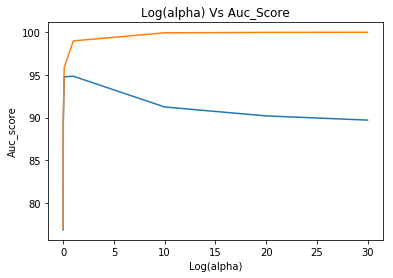

In [0]:
plt.plot(c,cv_scr)
plt.plot(c,train_scr)
plt.title("Log(alpha) Vs Auc_Score")
plt.xlabel("Log(alpha)")
plt.ylabel("Auc_score")
plt.show()

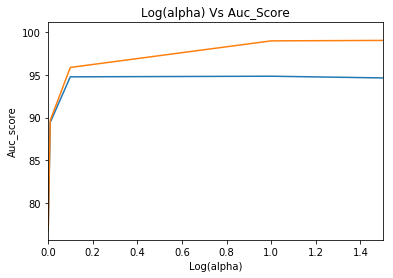

In [0]:
plt.plot(c,cv_scr)
plt.plot(c,train_scr)
plt.title("Log(alpha) Vs Auc_Score")
plt.xlabel("Log(alpha)")
plt.ylabel("Auc_score")
plt.xlim([0,1.5])
plt.show()

1. for **initial values** , auc score is low , about **0.76**...& there onwards it is increasing very fast and gives **max score for c=1**.
2. Further, Beyond c=1...AUC_SCORE is again reducing gradually.
2. In our case we will proceed with **c=1** as it is giving best result with **AUC_SCORE of 0.9482**

In [0]:
from sklearn.linear_model import LogisticRegression
lr_model=LogisticRegression(C=1,penalty='l1')
lr_model.fit(final_counts_train,final['Score'][:60000])

"""Training Data"""
pred_prob_train=lr_model.predict_proba(final_counts_train)
pred_train=lr_model.predict(final_counts_train)

In [0]:
"""Test Data"""
pred_prob_test=lr_model.predict_proba(final_counts_test)
pred_test=lr_model.predict(final_counts_test)

No handles with labels found to put in legend.


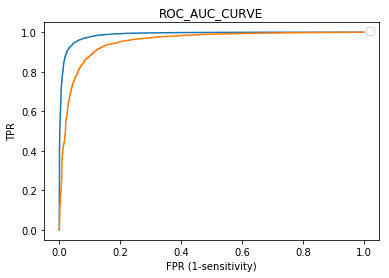

In [0]:
fpr1,tpr1,thr1=roc_curve(final['Score'][:60000],pred_prob_train[:,1])
fpr2,tpr2,thr2=roc_curve(final['Score'][60000:80000],pred_prob_test[:,1])
plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.title("ROC_AUC_CURVE")
plt.xlabel("FPR (1-sensitivity)")
plt.ylabel("TPR")
plt.legend()

plt.show()

In [0]:
roc_auc_score(final['Score'][:60000],pred_prob_train[:,1])


0.9881857005716143

In [0]:
roc_auc_score(final['Score'][60000:80000],pred_prob_test[:,1])


0.9515171517618357

**SET - 1**

1. Looking at above ROC_CURVE and its corresponding values it seems that model is doing well on training and test data.
2. There is a Very small gap between train and test ROC_CURVE with **difference of only 0.03**
3. Model is showing **better AUC_SCORE on test data than CV data**. Which is highly desirable.

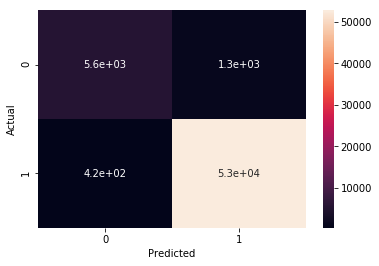

In [0]:

from sklearn.metrics import confusion_matrix

cmat_train = confusion_matrix(final['Score'][:60000],pred_train)

sns.heatmap(cmat_train,annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

1. it seems that **Negative reviews** in train_data are being **wrongly classified** as positive.
2. Also decent quantity of **positive reviews** in train_data are being **wrongly classified** as negative.

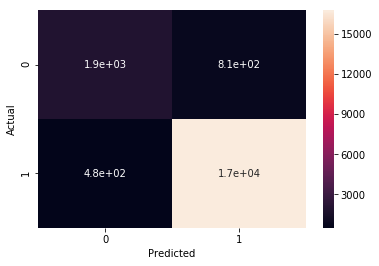

In [0]:
cmat_test = confusion_matrix(final['Score'][60000:80000],pred_test)

sns.heatmap(cmat_test,annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

1. Model performance **on test data** is **quite similar with positive reviews** as on train data few posotive reviews are being wrongly claassified as negative.
2. While , model is showing **better performance with negative reviews** on test data than train_data

In [0]:
from sklearn.metrics import classification_report

train_report=classification_report(final['Score'][:60000],pred_train)
print(train_report)

              precision    recall  f1-score   support

           0       0.93      0.81      0.87      6853
           1       0.98      0.99      0.98     53147

    accuracy                           0.97     60000
   macro avg       0.95      0.90      0.92     60000
weighted avg       0.97      0.97      0.97     60000



In [0]:
test_report=classification_report(final['Score'][60000:80000],pred_test)
print(test_report)

              precision    recall  f1-score   support

           0       0.80      0.70      0.75      2742
           1       0.95      0.97      0.96     17258

    accuracy                           0.94     20000
   macro avg       0.88      0.84      0.86     20000
weighted avg       0.93      0.94      0.93     20000



1. Notice that, model is performing very well on test data
2. There is **no significance difference** between model performance on **train & test data.**
3. But by looking at recall, precision and f1-score for positive & negative reviews...we can notice that...model on Class 0 i.e negative reviews is not well generalised as there is a **difference between PRECISION,RECALL and F1-SCORE of positive & negative reviews on test data**
4. Overall Model is well **generalised**

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
w=lr_model.coef_
print(w)

[[ 0.          0.21898022  0.         ... -0.22939568  0.
   0.        ]]


In [0]:
np.count_nonzero(w)

3391

In [0]:
sparsity=(w.size-np.count_nonzero(w))/w.size
print("Sparsity of a Weight matrix is :- %s " %(sparsity*100))

Sparsity of a Weight matrix is :- 51.55714285714286 


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score,roc_curve
c=[0.001, 0.01, 0.1, 1, 10, 20,30]

train_scr=[]
cv_scr=[]
for val in tqdm(c):
  
  lr_model=LogisticRegression(C=val,penalty='l2')
  auc_score=cross_validate(lr_model,final_counts_train,final['Score'][:60000],scoring='roc_auc',cv=5,return_train_score=True) # maybe here we have to pass sparse matrix...rather than bow_train_df->final_counts(sp_mat)
  train_scr.append(auc_score['train_score'].mean()*100)
  cv_scr.append(auc_score['test_score'].mean()*100)
  print("roc_auc score for c=%s is :- %s " %(val,auc_score['test_score'].mean()))

 14%|█▍        | 1/7 [00:01<00:11,  1.91s/it]

roc_auc score for c=0.001 is :- 0.9071148870529955 


 29%|██▊       | 2/7 [00:05<00:12,  2.44s/it]

roc_auc score for c=0.01 is :- 0.9445190827514705 


 43%|████▎     | 3/7 [00:13<00:16,  4.09s/it]

roc_auc score for c=0.1 is :- 0.9539092520094608 


 57%|█████▋    | 4/7 [00:30<00:23,  7.94s/it]

roc_auc score for c=1 is :- 0.9458398673102648 


 71%|███████▏  | 5/7 [01:16<00:38, 19.32s/it]

roc_auc score for c=10 is :- 0.9273645195030935 


 86%|████████▌ | 6/7 [01:57<00:25, 25.86s/it]

roc_auc score for c=20 is :- 0.9276678143592573 


100%|██████████| 7/7 [02:40<00:00, 31.15s/it]

roc_auc score for c=30 is :- 0.9249723157106591 


1. With **L2 Regularization** , model is performing **well for a wide range of C (1/lambda)**.
2. And the highest AUC_SCORE is for **c=0.1** unlike in L1 regularization case, where model was performing well for c=1
3. Also, the AUC_SCORE with L2 regularization is slightly better than with L1 regularization. **Difference of 0.0097 in AUC_SCORE from L1 to L2 regularization**

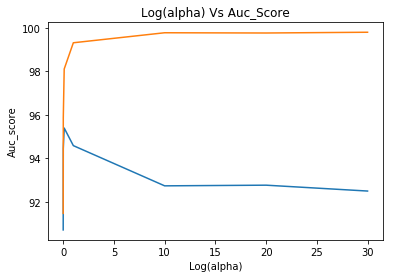

In [0]:

plt.plot(c,cv_scr)
plt.plot(c,train_scr)
plt.title("Log(alpha) Vs Auc_Score")
plt.xlabel("Log(alpha)")
plt.ylabel("Auc_score")
plt.show()

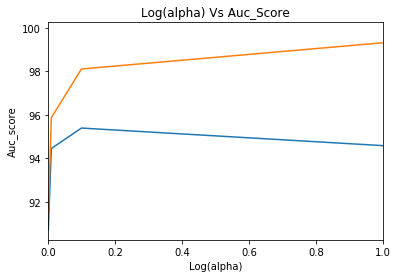

In [0]:
plt.plot(c,cv_scr)
plt.plot(c,train_scr)
plt.title("Log(alpha) Vs Auc_Score")
plt.xlabel("Log(alpha)")
plt.ylabel("Auc_score")
plt.xlim([0,1])
plt.show()

1. We can notice from ROC_AUC curve that, for values of C less than 5...model is giving best AUC_SCORE on test data.
2. Even after increasing the value of C beyond 20...model performance is still steady with approx same AUC_SCORE
3.Model with L2 regularization is showing **less variance in AUC_SCORE** with increase in value of C (hyperparameter) than model with L1 regulrization
2. One thing is to be noticed that, with both **L1 & L2** regularization, **AUC_SCORE on training data is exceptionally well.**

In [0]:

from sklearn.linear_model import LogisticRegression
lr_model=LogisticRegression(C=0.1,penalty='l2')
lr_model.fit(final_counts_train,final['Score'][:60000])

"""Training Data"""
pred_prob_train=lr_model.predict_proba(final_counts_train)
pred_train=lr_model.predict(final_counts_train)

In [0]:
"""Test Data"""
pred_prob_test=lr_model.predict_proba(final_counts_test)
pred_test=lr_model.predict(final_counts_test)

No handles with labels found to put in legend.


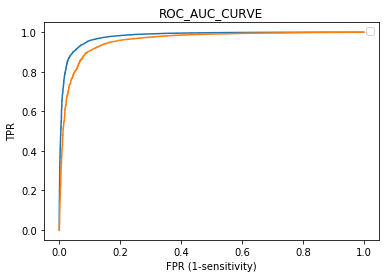

In [0]:
fpr1,tpr1,thr1=roc_curve(final['Score'][:60000],pred_prob_train[:,1])
fpr2,tpr2,thr2=roc_curve(final['Score'][60000:80000],pred_prob_test[:,1])
plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.title("ROC_AUC_CURVE")
plt.xlabel("FPR (1-sensitivity)")
plt.ylabel("TPR")
plt.legend()

plt.show()

In [0]:
roc_auc_score(final['Score'][:60000],pred_prob_train[:,1])



0.9799818825287301

In [0]:

roc_auc_score(final['Score'][60000:80000],pred_prob_test[:,1])

0.9587147778017556

1. As expected model is performing really good on tran & test data with AUC_SCORE **greater than 0.95** on both train & test data
2. There is a **difference of about 0.02** between AUC_SCORE of train and test data.
3. AUC_SCORE on CV data was around 0.95 and model is giving **same AUC_SCORE on test data as well.**

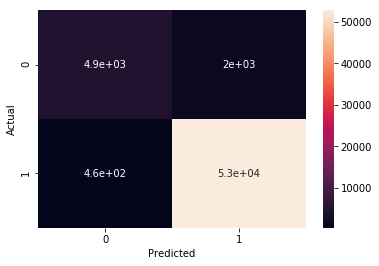

In [0]:

from sklearn.metrics import confusion_matrix

cmat_train = confusion_matrix(final['Score'][:60000],pred_train)

sns.heatmap(cmat_train,annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

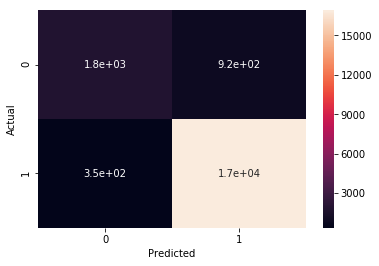

In [0]:
cmat_test = confusion_matrix(final['Score'][60000:80000],pred_test)

sns.heatmap(cmat_test,annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

1. Model is showing **same behaviur as the ones before**.
2. On train data...model is wrongly predicting some datapoints from positive and negative class.
3. While on test data, model is performing slightly better on negative reviews, same as the model before.

In [0]:
from sklearn.metrics import classification_report

train_report=classification_report(final['Score'][:60000],pred_train)
print(train_report)


              precision    recall  f1-score   support

           0       0.91      0.71      0.80      6853
           1       0.96      0.99      0.98     53147

    accuracy                           0.96     60000
   macro avg       0.94      0.85      0.89     60000
weighted avg       0.96      0.96      0.96     60000



In [0]:
test_report=classification_report(final['Score'][60000:80000],pred_test)
print(test_report)

              precision    recall  f1-score   support

           0       0.84      0.66      0.74      2742
           1       0.95      0.98      0.96     17258

    accuracy                           0.94     20000
   macro avg       0.89      0.82      0.85     20000
weighted avg       0.93      0.94      0.93     20000



1. Again we can notice the difference in scores for positive & negative reviews on train & test data.
2. For positive reviews , model is doing well. But like the model before , this model is again performing slightly poor on negative reviews.

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [0]:
"""
Steps:-
1. Train model on data X
2. Get weight matrix w, for that model.
3. Add some very small error (Noise) to X i.e X'=X
4. Now train model (another one) on data X'
5. Get its weight matrix w'
6. add some small value (10^-6) to avoid w and w' to avoid "division by zero" situation 
as we wil be calculating % change in weight vector's values at multiple intervals , likw 10th,25th,50th Percentile
"""

In [0]:
# get weight vector of model 1
w1=list(lr_model.coef_[0])
print(w1)

[0.09289769521667127, 0.15784673411618338, -0.03427727675292371, 0.19306125658238982, 0.11510772706669191, 0.0039585062640604815, 0.019802339711856794, 0.06328170043873878, -0.007881176669009157, 0.08203127673085993, 0.29366565449960147, -0.03239425226809767, -0.12990377752230928, -0.09616396522421197, 0.07073509519333993, 0.10486618007399591, -0.08426154879710715, 0.014299572343168393, 0.06483633575490787, -0.006089215075460799, 0.030477563535197535, -0.1727522766056489, 0.316903950610823, 0.012236404812787266, 0.08996853249173921, 0.06318209301531127, -0.03962486054295088, -0.16729974487355, -0.17109527907122432, -0.11554067530391747, 0.2766764336518332, 0.18874051842990133, 0.07016168529515113, 0.40033242911504296, 0.24769955401102933, 0.3203466029260595, -0.007669287774714985, -0.11774361877777985, 0.09411488042990039, 0.012289605739192348, -0.05681311211040464, 0.0027339698001587576, -0.19899597719056622, 0.07795081104849926, -0.22944992873715334, -0.057085118526901686, 0.03362624

In [0]:
e=np.random.uniform(0,0.1)
# its a noise value (error) that will be added to data X, to get X'(X_).

In [0]:
final_counts_train.data=final_counts_train.data+e

In [0]:
print(final_counts_train)

In [0]:

lr_model=LogisticRegression(C=0.1,penalty='l2')
lr_model.fit(final_counts_train,final['Score'][:60000])

"""Training Data"""

'Training Data'

In [0]:
# Now get the weight vector of the model 2

w2 = lr_model.coef_
print(w2)
# also try to implement pertubation test


[[ 0.0928977   0.15784673 -0.03427728 ... -0.14473228 -0.06878063
  -0.03752372]]


In [0]:
# add small value to w1 and w2 to avoid "division by zero situation"
w1=w1+0.000001
w2=w2+0.000001

In [0]:
# get the percentage change in weight vector's elements
weight_per=list((np.abs((w1-w2)/w1)*100)[0])

In [0]:
weight_per_sorted=list((np.abs((w1-w2)/w1)*100)[0])

In [0]:
weight_per_sorted.sort()

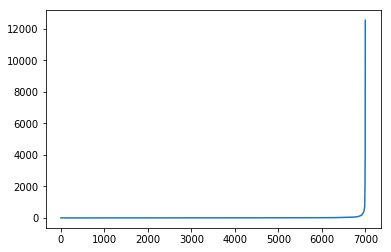

In [0]:
# we have got the array i.e per_change_weight vector
# use this further to plot the desired graph
# accordingly find out the threshold value for per_change...
# if certain element from weight vector is changing by above that value(threshold) then there exists a colinearity in data features
plt.plot(weight_per_sorted)
plt.show()

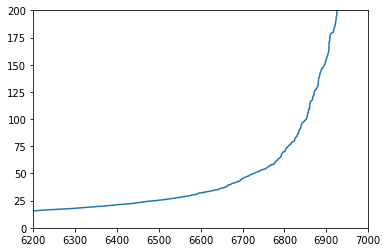

In [0]:
plt.plot(weight_per_sorted)
plt.ylim([0,200])
plt.xlim([6200,7000])
plt.show()

1. Looking at above plot we can say that, there is no sudden raise as such till 6700
2. So lets now zoom in the plot more from 6700 onwards.

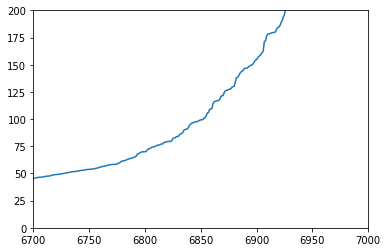

In [0]:
# Zoom in the plot
plt.plot(weight_per_sorted)
plt.ylim([0,200])
plt.xlim([6700,7000])
plt.show()

1. As we can notice that, there is no sudden raise as such in percentage change value from 6700 onwards also.
2. Lets check the percentag change value between 6700 and 6800

In [0]:
weight_per_sorted[6700:6800]

[45.303432822204655,
 45.61720038016775,
 45.73146824317595,
 45.98660605399618,
 46.3665455797273,
 46.42066704701365,
 46.44872329944087,
 46.48355902311264,
 46.666597169441076,
 46.90858158168863,
 47.124931705278,
 47.24147633648268,
 47.51786925803152,
 47.5207432516651,
 47.62807924112344,
 47.73285557707765,
 48.154729593735176,
 48.49639970812207,
 48.615103833181,
 48.730493775465476,
 48.954040055059444,
 49.075877838512625,
 49.0919018097147,
 49.308524752304706,
 49.480303280535,
 49.574529736930366,
 49.82560253686953,
 49.93971119130715,
 50.24520840552055,
 50.382121969755985,
 50.46412923895877,
 50.69210731178229,
 51.05014759819476,
 51.21786115861586,
 51.44034219378841,
 51.49158863742896,
 51.704642508586296,
 51.71001561165467,
 51.82143453045222,
 52.124465881021706,
 52.16825656631817,
 52.35888690986371,
 52.69983039466896,
 52.71083905992465,
 52.96228426800131,
 52.973076860510474,
 53.23575415874229,
 53.35171670605122,
 53.592821110120816,
 53.704108140462

1. Note that, from 6700 onwards , there is no any sudden increase in percentage change value.
2. Lets zoom in the plot from 6800 onwards now.

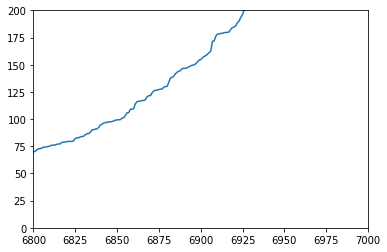

In [0]:
# Zoom in the plot
plt.plot(weight_per_sorted)
plt.ylim([0,200])
plt.xlim([6800,7000])
plt.show()

In [0]:
# wherever th change is sharp...those are the collinear features.
# lets check the values by printing them
weight_per_sorted[6850:6900]

[99.30078135288412,
 99.32790035237528,
 99.49947866523328,
 100.97955315946076,
 101.31610746467781,
 103.34427287185525,
 105.74669278380338,
 105.97441229543358,
 109.0331670712526,
 109.09660244431171,
 109.74234130460631,
 114.25447499306219,
 115.94187350452047,
 116.42432412587,
 116.58394440768265,
 117.028253666363,
 117.11248997554856,
 117.9066342430703,
 120.61715486659361,
 121.52642890997434,
 121.59514954023778,
 124.3129986875658,
 125.98215941083517,
 126.4676087121033,
 126.6681656158765,
 127.19536646128591,
 127.5316948467583,
 127.7107035726085,
 129.44538066023202,
 129.7997474204435,
 130.19651095659546,
 134.2510615226351,
 138.01450692765712,
 138.30809383540844,
 139.7284718737319,
 141.91416585677348,
 143.2315485614896,
 144.1173770880818,
 144.7139836720117,
 146.63454612292043,
 146.64771955551944,
 146.6518022738264,
 147.26576755887615,
 148.19958613948535,
 148.9417849654471,
 149.59521434669054,
 149.78878341100142,
 150.8877787882038,
 152.54661147283

1. We can notice that, there is a raise in percentage_change_value from 109 to 114.
2. So we can conclude that, 114-109 = 5% is the threshod value in our case.
3. Therefore from percentage_weight_change vector, **all the features showing % change of >5% are collinear features.**

In [0]:
# now lets get the indices of all the elements from weight_per vector whose value is >5

indices=[]
for ele in tqdm(weight_per):
  if ele > 5.0:
    indices.append(weight_per.index(ele))


100%|██████████| 7000/7000 [00:00<00:00, 27439.78it/s]


In [0]:
len(indices)

2848

1. There are **2848 collinear features** out of 7000 features **with 5% change as a threshold value.**

In [0]:
features=count_vect.get_feature_names()

In [0]:
collinear_features=[features[i] for i in indices]

In [0]:
collinear_features[2840:]
# sample collinear features

['zero', 'zesty', 'zinc', 'zip', 'ziploc', 'ziti', 'zucchini', 'zuke']

In [0]:
per_collinear_features=len(collinear_features)/len(features)*100
print(per_collinear_features)

40.68571428571428


**~ 40% of total features are collinear.**

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [0]:
w1_sorted=w1.copy()# to get top pos and top neg values
w1_sorted.sort()
w1_sorted[:10]

[-1.9262526917846008,
 -1.6356584195292614,
 -1.5326899906248057,
 -1.3859018386846753,
 -1.3794163092512817,
 -1.358268143342185,
 -1.3560086105168005,
 -1.2599600732438345,
 -1.1887229156326315,
 -1.1774487061805616]

In [0]:
top_10_pos_values=w1_sorted[6991:7001]

In [0]:
top_10_pos_values.sort(reverse=True)
top_10_pos_values

[1.5016421625089538,
 1.4689022970451222,
 1.27549362759441,
 1.2654785996237135,
 1.264847181641493,
 1.1954984079208038,
 1.1894135882892165,
 1.1865148776003183,
 1.1303674561914432]

In [0]:
top_10_pos_index=[w1.index(i) for i in top_10_pos_values]

In [0]:
top_10_pos_features=[features[i] for i in top_10_pos_index]
top_10_pos_features

['delicious',
 'excellent',
 'perfect',
 'yummy',
 'loves',
 'best',
 'wonderful',
 'yum',
 'great']

#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [0]:
top_10_neg_values=w1_sorted[:10]
top_10_neg_values

[-1.9262526917846008,
 -1.6356584195292614,
 -1.5326899906248057,
 -1.3859018386846753,
 -1.3794163092512817,
 -1.358268143342185,
 -1.3560086105168005,
 -1.2599600732438345,
 -1.1887229156326315,
 -1.1774487061805616]

In [0]:
top_10_neg_index=[w1.index(i) for i in top_10_neg_values]
top_10_neg_index

[6908, 1755, 6234, 369, 558, 6973, 2938, 1754, 1756, 6292]

In [0]:
top_10_neg_features=[features[i] for i in top_10_neg_index]
top_10_neg_features

['worst',
 'disappointing',
 'terrible',
 'awful',
 'bland',
 'yuck',
 'horrible',
 'disappointed',
 'disappointment',
 'threw']

# [5.2] Logistic Regression on  Bi-grams BOW

### [5.2.1] Applying Logistic Regression with L1 regularization on Bigram-BOW<font color='red'> </font>

In [0]:


# Please write all the code with proper documentation

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score,roc_curve
c=[0.001, 0.01, 0.1, 1, 10, 20,30]

train_scr=[]
cv_scr=[]
for val in tqdm(c):
  
  lr_model=LogisticRegression(C=val,penalty='l1')
  auc_score=cross_validate(lr_model,final_bigram_counts_train,final['Score'][:60000],scoring='roc_auc',cv=5,return_train_score=True) # maybe here we have to pass sparse matrix...rather than bow_train_df->final_counts(sp_mat)
  train_scr.append(auc_score['train_score'].mean()*100)
  cv_scr.append(auc_score['test_score'].mean()*100)
  print("roc_auc score for c=%s is :- %s " %(val,auc_score['test_score'].mean()))

 14%|█▍        | 1/7 [00:02<00:12,  2.12s/it]

roc_auc score for c=0.001 is :- 0.7685087421653731 


 29%|██▊       | 2/7 [00:04<00:10,  2.11s/it]

roc_auc score for c=0.01 is :- 0.8972350680919557 


 43%|████▎     | 3/7 [00:07<00:09,  2.43s/it]

roc_auc score for c=0.1 is :- 0.9540673399866483 


 57%|█████▋    | 4/7 [00:13<00:10,  3.61s/it]

roc_auc score for c=1 is :- 0.9557089992161968 


 71%|███████▏  | 5/7 [00:31<00:15,  7.92s/it]

roc_auc score for c=10 is :- 0.9313816964107534 


 86%|████████▌ | 6/7 [00:55<00:12, 12.82s/it]

roc_auc score for c=20 is :- 0.9276354730806358 


100%|██████████| 7/7 [01:24<00:00, 17.59s/it]

roc_auc score for c=30 is :- 0.9259872553308061 


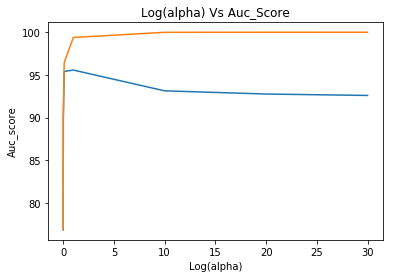

In [0]:
plt.plot(c,cv_scr)
plt.plot(c,train_scr)
plt.title("Log(alpha) Vs Auc_Score")
plt.xlabel("Log(alpha)")
plt.ylabel("Auc_score")
plt.show()

1. We can notice that, bigram bow is also showing same behaviour while training LR model.
2. Also L1 regularized model is showing variation in model performance with bigram bow also , like bow L1 regularized model.
3. Like with bow, bigram bow model is also giving higher AUC_SCORE for c=1

In [0]:

from sklearn.linear_model import LogisticRegression
lr_model=LogisticRegression(C=1,penalty='l1')
lr_model.fit(final_bigram_counts_train,final['Score'][:60000])

"""Training Data"""
pred_prob_train=lr_model.predict_proba(final_bigram_counts_train)
pred_train=lr_model.predict(final_bigram_counts_train)




In [0]:


"""Test Data"""
pred_prob_test=lr_model.predict_proba(final_bigram_counts_test)
pred_test=lr_model.predict(final_counts_test)



No handles with labels found to put in legend.


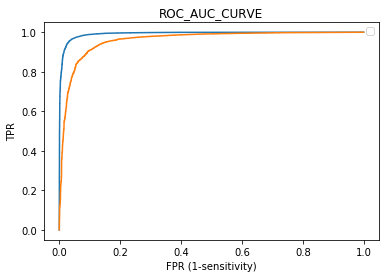

In [0]:
fpr1,tpr1,thr1=roc_curve(final['Score'][:60000],pred_prob_train[:,1])
fpr2,tpr2,thr2=roc_curve(final['Score'][60000:80000],pred_prob_test[:,1])
plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.title("ROC_AUC_CURVE")
plt.xlabel("FPR (1-sensitivity)")
plt.ylabel("TPR")
plt.legend()

plt.show()

In [0]:
roc_auc_score(final['Score'][:60000],pred_prob_train[:,1])



0.9928148277653984

In [0]:
roc_auc_score(final['Score'][60000:80000],pred_prob_test[:,1])


0.9600565587231967

1. Looking at above AUC score, it seems that model is **performing exceptionally well** on train as well as on test data.

2. AUC score on train and test data is slightly **better than that of unigram bow LR model.**


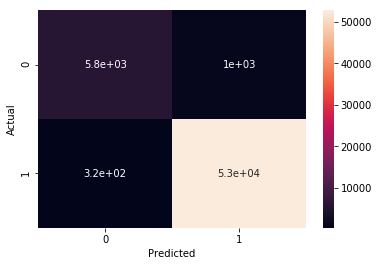

In [0]:

from sklearn.metrics import confusion_matrix

cmat_train = confusion_matrix(final['Score'][:60000],pred_train)

sns.heatmap(cmat_train,annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()



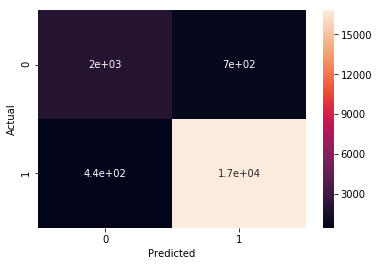

In [0]:
cmat_test = confusion_matrix(final['Score'][60000:80000],pred_test)

sns.heatmap(cmat_test,annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

1. Like in unigram, here also , model is somewhat performing poor with negative reviews, as some negative reviews are being wrongly classified as positive.

2. Even though there are few positive reviews being wrongly classified as negative , but it is in lesser quantity.

3. **Overall,** when comparing **1-gram vs Bi-gram**...both models are **performing almost same.**

4. But coming to generalisation, Bi-gram based model is performing very well on unseen data. i.e **Bi-gram based model is highly generalised.**

In [0]:
from sklearn.metrics import classification_report

train_report=classification_report(final['Score'][:60000],pred_train)
print(train_report)


              precision    recall  f1-score   support

           0       0.95      0.85      0.90      6853
           1       0.98      0.99      0.99     53147

    accuracy                           0.98     60000
   macro avg       0.96      0.92      0.94     60000
weighted avg       0.98      0.98      0.98     60000



In [0]:
test_report=classification_report(final['Score'][60000:80000],pred_test)
print(test_report)

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      2742
           1       0.96      0.97      0.97     17258

    accuracy                           0.94     20000
   macro avg       0.89      0.86      0.87     20000
weighted avg       0.94      0.94      0.94     20000



### [5.2.2] Applying Logistic Regression with L2 regularization on Bigram-BOW<font color='red'> </font>

In [0]:

# Please write all the code with proper documentation

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score,roc_curve
c=[0.001, 0.01, 0.1, 1, 10, 20,30]

train_scr=[]
cv_scr=[]
for val in tqdm(c):
  
  lr_model=LogisticRegression(C=val,penalty='l2')
  auc_score=cross_validate(lr_model,final_bigram_counts_train,final['Score'][:60000],scoring='roc_auc',cv=5,return_train_score=True) # maybe here we have to pass sparse matrix...rather than bow_train_df->final_counts(sp_mat)
  train_scr.append(auc_score['train_score'].mean()*100)
  cv_scr.append(auc_score['test_score'].mean()*100)
  print("roc_auc score for c=%s is :- %s " %(val,auc_score['test_score'].mean()))



 14%|█▍        | 1/7 [00:04<00:25,  4.29s/it]

roc_auc score for c=0.001 is :- 0.9118713638235224 


 29%|██▊       | 2/7 [00:11<00:25,  5.18s/it]

roc_auc score for c=0.01 is :- 0.950526722180736 


 43%|████▎     | 3/7 [00:31<00:37,  9.47s/it]

roc_auc score for c=0.1 is :- 0.9608682358938097 


 57%|█████▋    | 4/7 [01:11<00:56, 18.85s/it]

roc_auc score for c=1 is :- 0.9534374165178242 


 71%|███████▏  | 5/7 [02:43<01:21, 40.77s/it]

roc_auc score for c=10 is :- 0.9390772713030374 


 86%|████████▌ | 6/7 [04:35<01:01, 61.95s/it]

roc_auc score for c=20 is :- 0.9356504832292621 


100%|██████████| 7/7 [06:32<00:00, 78.52s/it]

roc_auc score for c=30 is :- 0.9343771160413284 


1. Again as expected , L2 regularized model , with Bigram-BOW, like unigram-BOW is showing less variations with model performance.
2. But again, like with L1 regularized model, Bigram-BOW is showing slightly better performance than unigram-BOW model with L2 regularization as well.
3. **C=0.1** is found out to be the best value with an **AUC_SCORE of ~0.96**

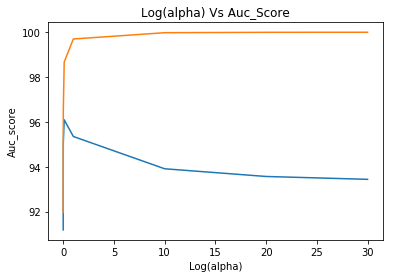

In [0]:
plt.plot(c,cv_scr)
plt.plot(c,train_scr)
plt.title("Log(alpha) Vs Auc_Score")
plt.xlabel("Log(alpha)")
plt.ylabel("Auc_score")
plt.show()



In [0]:
from sklearn.linear_model import LogisticRegression
lr_model=LogisticRegression(C=0.1,penalty='l2')
lr_model.fit(final_bigram_counts_train,final['Score'][:60000])

"""Training Data"""
pred_prob_train=lr_model.predict_proba(final_bigram_counts_train)
pred_train=lr_model.predict(final_bigram_counts_train)


In [0]:
"""Test Data"""
pred_prob_test=lr_model.predict_proba(final_bigram_counts_test)
pred_test=lr_model.predict(final_bigram_counts_test)



No handles with labels found to put in legend.


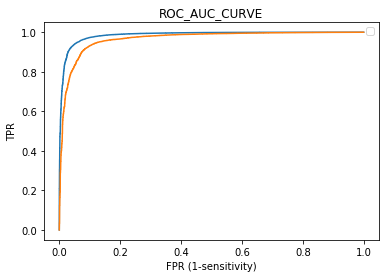

In [0]:
fpr1,tpr1,thr1=roc_curve(final['Score'][:60000],pred_prob_train[:,1])
fpr2,tpr2,thr2=roc_curve(final['Score'][60000:80000],pred_prob_test[:,1])
plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.title("ROC_AUC_CURVE")
plt.xlabel("FPR (1-sensitivity)")
plt.ylabel("TPR")
plt.legend()

plt.show()

In [0]:
roc_auc_score(final['Score'][:60000],pred_prob_train[:,1])

0.9855933405808747

In [0]:
roc_auc_score(final['Score'][60000:80000],pred_prob_test[:,1])

0.9658508038513456

1. Bigram-BOW LR model is showing very good performance.
2. There is a slight difference in AUC_SCORE of Bigram-BOW LR model with L1 reguarization & L2 regularization. L2 regularized model slightly being lagging behind when it comes to train data.
3. On the other hand, on test data, Bigram-BOW LR model is performing almost similar with L1 & L2 regularization.

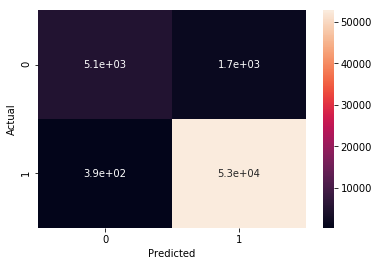

In [0]:

from sklearn.metrics import confusion_matrix

cmat_train = confusion_matrix(final['Score'][:60000],pred_train)

sns.heatmap(cmat_train,annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()



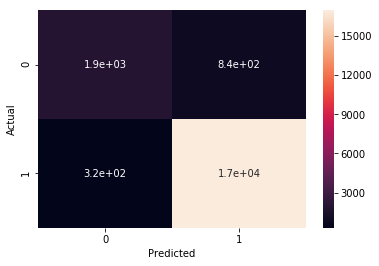

In [0]:
cmat_test = confusion_matrix(final['Score'][60000:80000],pred_test)

sns.heatmap(cmat_test,annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()




1. Performance with positive and negative reviews is very much similar to all previous models.
2. i.e wrongly predicting few positive & some negative reviews on train data but again showing better performance on test data, specially with negative reviews.

In [0]:
from sklearn.metrics import classification_report

train_report=classification_report(final['Score'][:60000],pred_train)
print(train_report)



              precision    recall  f1-score   support

           0       0.93      0.75      0.83      6853
           1       0.97      0.99      0.98     53147

    accuracy                           0.97     60000
   macro avg       0.95      0.87      0.91     60000
weighted avg       0.96      0.97      0.96     60000



In [0]:

test_report=classification_report(final['Score'][60000:80000],pred_test)
print(test_report)

              precision    recall  f1-score   support

           0       0.86      0.69      0.77      2742
           1       0.95      0.98      0.97     17258

    accuracy                           0.94     20000
   macro avg       0.90      0.84      0.87     20000
weighted avg       0.94      0.94      0.94     20000



### [5.2.3] Feature Importance on Bigram-BOW,<font color='red'> </font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> </font>

In [0]:
bigram_features=count_vect_bigram.get_feature_names()
# getting features of Bigram BOW vectorized text data


In [0]:
w1=list(lr_model.coef_[0])
type(w1)


list

In [0]:
w1_sorted=w1.copy()
w1_sorted.sort()
w1_sorted[:10]

[-1.8275709830719393,
 -1.6733128652934257,
 -1.6269220511320481,
 -1.5938300811515194,
 -1.5383725454789883,
 -1.5255117529124647,
 -1.4398310347203733,
 -1.4070842490863076,
 -1.3696077284044523,
 -1.3637889587360987]

In [0]:
top_10_pos_values=w1_sorted[6990:]
top_10_pos_values.sort(reverse=True)
top_10_pos_values

[1.5533339963025041,
 1.4657207782213015,
 1.3975007947220586,
 1.2663317888953787,
 1.2597769099296052,
 1.258075323650699,
 1.236562758897812,
 1.1917590821149324,
 1.1724702593638587,
 1.1205015519964536]

In [0]:
top_10_pos_index=[w1.index(i) for i in top_10_pos_values]
top_10_pos_index

[1458, 1887, 4087, 4565, 6989, 3528, 462, 6847, 2615, 4063]

In [0]:
top_10_pos_bigram_features=[bigram_features[i] for i in top_10_pos_index]
top_10_pos_bigram_features


['delicious',
 'excellent',
 'not disappointed',
 'perfect',
 'yummy',
 'loves',
 'best',
 'wonderful',
 'great',
 'not bad']

#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> </font>

In [0]:
top_10_neg_values=w1_sorted[:10]
top_10_neg_index=[w1.index(i) for i in top_10_neg_values]
top_10_neg_bigram_features=[bigram_features[i] for i in top_10_neg_index]
top_10_neg_bigram_features

['worst',
 'not worth',
 'disappointing',
 'not great',
 'terrible',
 'disappointed',
 'not good',
 'awful',
 'horrible',
 'bland']

## [5.3] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [0]:





# Please write all the code with proper documentation

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score,roc_curve
c=[0.001, 0.01, 0.1, 1, 10, 20,30]

train_scr=[]
cv_scr=[]
for val in tqdm(c):
  
  lr_model=LogisticRegression(C=val,penalty='l1')
  auc_score=cross_validate(lr_model,final_tf_idf_train,final['Score'][:60000],scoring='roc_auc',cv=5,return_train_score=True) # maybe here we have to pass sparse matrix...rather than bow_train_df->final_counts(sp_mat)
  train_scr.append(auc_score['train_score'].mean()*100)
  cv_scr.append(auc_score['test_score'].mean()*100)
  print("roc_auc score for c=%s is :- %s " %(val,auc_score['test_score'].mean()))



 14%|█▍        | 1/7 [00:00<00:05,  1.16it/s]

roc_auc score for c=0.001 is :- 0.5 


 29%|██▊       | 2/7 [00:02<00:05,  1.00s/it]

roc_auc score for c=0.01 is :- 0.7250274736529622 


 43%|████▎     | 3/7 [00:04<00:05,  1.32s/it]

roc_auc score for c=0.1 is :- 0.9178999680589683 


 57%|█████▋    | 4/7 [00:08<00:06,  2.11s/it]

roc_auc score for c=1 is :- 0.9593171716239868 


 71%|███████▏  | 5/7 [00:19<00:09,  4.94s/it]

roc_auc score for c=10 is :- 0.9496100247917978 


 86%|████████▌ | 6/7 [00:36<00:08,  8.61s/it]

roc_auc score for c=20 is :- 0.9383954265757225 


100%|██████████| 7/7 [00:58<00:00, 12.39s/it]

roc_auc score for c=30 is :- 0.9311965904372203 


1. To be noticed here, though Bow & Bigram-Bow were showing variations in model performance with L1 regularization, TFIDF is showing **very high variations in model performance** with AUC_SCORE varying from **0.5 to 0.95....**
2. But similar to Bow & Bigram-Bow , it is still giving better performance with AUC_SCORE of **~0.96**

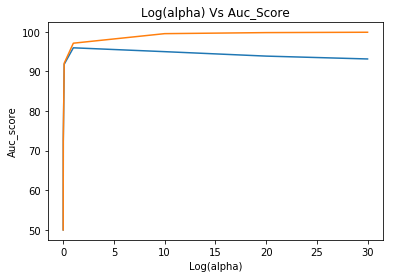

In [0]:

plt.plot(c,cv_scr)
plt.plot(c,train_scr)
plt.title("Log(alpha) Vs Auc_Score")
plt.xlabel("Log(alpha)")
plt.ylabel("Auc_score")
plt.show()



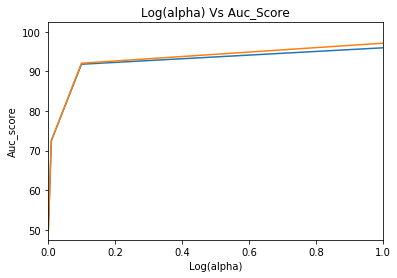

In [0]:
plt.plot(c,cv_scr)
plt.plot(c,train_scr)
plt.xlim([0,1])
plt.title("Log(alpha) Vs Auc_Score")
plt.xlabel("Log(alpha)")
plt.ylabel("Auc_score")
plt.show()



In [0]:

from sklearn.linear_model import LogisticRegression
lr_model=LogisticRegression(C=1,penalty='l1')
lr_model.fit(final_tf_idf_train,final['Score'][:60000])

"""Training Data"""
pred_prob_train=lr_model.predict_proba(final_tf_idf_train)
pred_train=lr_model.predict(final_tf_idf_train)




In [0]:

"""Test Data"""
pred_prob_test=lr_model.predict_proba(final_tf_idf_test)
pred_test=lr_model.predict(final_tf_idf_test)


No handles with labels found to put in legend.


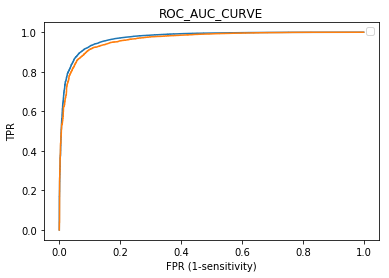

In [0]:


fpr1,tpr1,thr1=roc_curve(final['Score'][:60000],pred_prob_train[:,1])
fpr2,tpr2,thr2=roc_curve(final['Score'][60000:80000],pred_prob_test[:,1])
plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.title("ROC_AUC_CURVE")
plt.xlabel("FPR (1-sensitivity)")
plt.ylabel("TPR")
plt.legend()

plt.show()

In [0]:
roc_auc_score(final['Score'][:60000],pred_prob_train[:,1])

0.9718593458359758

In [0]:
roc_auc_score(final['Score'][60000:80000],pred_prob_test[:,1])

0.9637351875796837

1. Notice here, though TFIDF is giving lesser AUC_SCORE on train data than BOW and Bigram-BOW, But AUC SCORE on test data is still very much similar.
2. One more thing to be noticed here is, there is **very less difference between AUC_SCORE of train & CV data.**..unlike in case of BOW & Bigram-BOW. Which indicates, **TFIDF tokenization can build very high generalised model.**

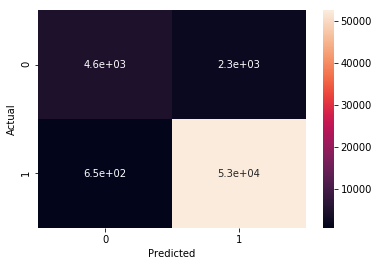

In [0]:

from sklearn.metrics import confusion_matrix

cmat_train = confusion_matrix(final['Score'][:60000],pred_train)

sns.heatmap(cmat_train,annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()





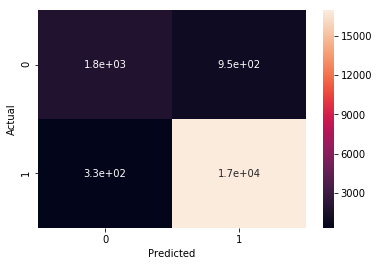

In [0]:
cmat_test = confusion_matrix(final['Score'][60000:80000],pred_test)

sns.heatmap(cmat_test,annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


1. Similar to previous two models, TFIDF based LR model is performing **better on positive reviews from test dataset & train data**.
2. While again, wrongly predicting few positive as well as some negative reviews from train dataset.

In [0]:
from sklearn.metrics import classification_report

train_report=classification_report(final['Score'][:60000],pred_train)
print(train_report)


              precision    recall  f1-score   support

           0       0.88      0.67      0.76      6853
           1       0.96      0.99      0.97     53147

    accuracy                           0.95     60000
   macro avg       0.92      0.83      0.87     60000
weighted avg       0.95      0.95      0.95     60000



In [0]:
test_report=classification_report(final['Score'][60000:80000],pred_test)
print(test_report)

              precision    recall  f1-score   support

           0       0.84      0.65      0.74      2742
           1       0.95      0.98      0.96     17258

    accuracy                           0.94     20000
   macro avg       0.90      0.82      0.85     20000
weighted avg       0.93      0.94      0.93     20000



1. As we have earlier mentioned that, TFIDF is seeming to be capable of developing highly generalised model.
2. We can look at the Classification report where we are able to see that, **from train to test data, performance metrics are showing very small difference** unlike in other previous cases. Which indicates , **TFIDF can build a highly generalised model**.

### [5.3.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [0]:



# Please write all the code with proper documentation

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score,roc_curve
c=[0.001, 0.01, 0.1, 1, 10, 20,30]

train_scr=[]
cv_scr=[]
for val in tqdm(c):
  
  lr_model=LogisticRegression(C=val,penalty='l2')
  auc_score=cross_validate(lr_model,final_tf_idf_train,final['Score'][:60000],scoring='roc_auc',cv=5,return_train_score=True) # maybe here we have to pass sparse matrix...rather than bow_train_df->final_counts(sp_mat)
  train_scr.append(auc_score['train_score'].mean()*100)
  cv_scr.append(auc_score['test_score'].mean()*100)
  print("roc_auc score for c=%s is :- %s " %(val,auc_score['test_score'].mean()))




 14%|█▍        | 1/7 [00:01<00:11,  1.96s/it]

roc_auc score for c=0.001 is :- 0.9093934229891343 


 29%|██▊       | 2/7 [00:04<00:10,  2.10s/it]

roc_auc score for c=0.01 is :- 0.9266191181668892 


 43%|████▎     | 3/7 [00:08<00:10,  2.67s/it]

roc_auc score for c=0.1 is :- 0.9480860260315934 


 57%|█████▋    | 4/7 [00:14<00:11,  3.68s/it]

roc_auc score for c=1 is :- 0.9621458481624989 


 71%|███████▏  | 5/7 [00:24<00:11,  5.70s/it]

roc_auc score for c=10 is :- 0.9600172838390393 


 86%|████████▌ | 6/7 [00:36<00:07,  7.55s/it]

roc_auc score for c=20 is :- 0.9564971901749381 


100%|██████████| 7/7 [00:49<00:00,  9.03s/it]

roc_auc score for c=30 is :- 0.9538451380576223 


1. With L2 regularization, TFIDF is behaving similar to Bow & Bigram-Bow by showing less variations in model performance.
2. But unlike BOW & Bigram-BOW, **TFIDF is performing well on higher values of C (1/lambda)**
3. In this case, we are geting higher AUC_SCORE for **c=1.**

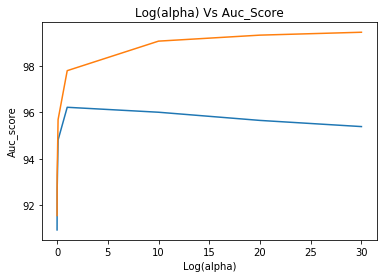

In [0]:
plt.plot(c,cv_scr)
plt.plot(c,train_scr)
plt.title("Log(alpha) Vs Auc_Score")
plt.xlabel("Log(alpha)")
plt.ylabel("Auc_score")
plt.show()




Above plot also indicates that ... **with C increasing, there is a gradual decrease in AUC_SCORE of model not more than 1.** Which indicates , model is performing well with higher values of C also.

In [0]:

from sklearn.linear_model import LogisticRegression
lr_model=LogisticRegression(C=1,penalty='l2')
lr_model.fit(final_tf_idf_train,final['Score'][:60000])

"""Training Data"""
pred_prob_train=lr_model.predict_proba(final_tf_idf_train)
pred_train=lr_model.predict(final_tf_idf_train)




In [0]:

"""Test Data"""
pred_prob_test=lr_model.predict_proba(final_tf_idf_test)
pred_test=lr_model.predict(final_tf_idf_test)



No handles with labels found to put in legend.


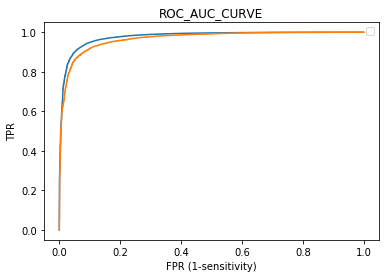

In [0]:
fpr1,tpr1,thr1=roc_curve(final['Score'][:60000],pred_prob_train[:,1])
fpr2,tpr2,thr2=roc_curve(final['Score'][60000:80000],pred_prob_test[:,1])
plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.title("ROC_AUC_CURVE")
plt.xlabel("FPR (1-sensitivity)")
plt.ylabel("TPR")
plt.legend()

plt.show()

In [0]:
roc_auc_score(final['Score'][:60000],pred_prob_train[:,1])

0.9774137032179862

In [0]:

roc_auc_score(final['Score'][60000:80000],pred_prob_test[:,1])

0.9669587161302543

1. With L2 regularization also, TFIDF based LR model is showing very small difference in AUC SCORE from train data to test data unlike BOW & Bigram-BOW.
2. Again, with L2 regularization also, it seems that, TFIDF can build a hghly generalised model.

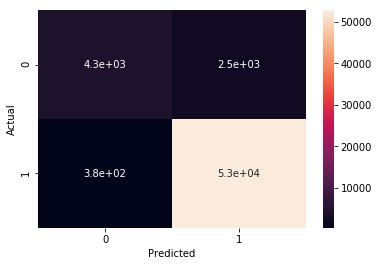

In [0]:

from sklearn.metrics import confusion_matrix

cmat_train = confusion_matrix(final['Score'][:60000],pred_train)

sns.heatmap(cmat_train,annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()






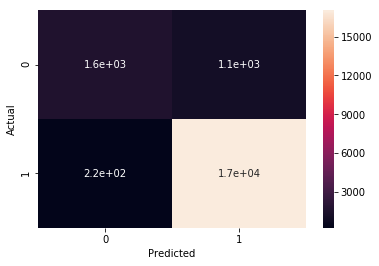

In [0]:

cmat_test = confusion_matrix(final['Score'][60000:80000],pred_test)

sns.heatmap(cmat_test,annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


1. Here we picked one **drawback with TFIDF**...it is unable to perform well on  negative reviews as **unlike BOW & Bigram-BOW, it is not doing so well on test data** as it is wrongly predicting some negative reviews from train as well as test dataset. There is no any improvement in model perfiormance on test data from train data as in previous cases.

In [0]:

from sklearn.metrics import classification_report

train_report=classification_report(final['Score'][:60000],pred_train)
print(train_report)


              precision    recall  f1-score   support

           0       0.92      0.63      0.75      6853
           1       0.95      0.99      0.97     53147

    accuracy                           0.95     60000
   macro avg       0.94      0.81      0.86     60000
weighted avg       0.95      0.95      0.95     60000



In [0]:

test_report=classification_report(final['Score'][60000:80000],pred_test)
print(test_report)

              precision    recall  f1-score   support

           0       0.88      0.59      0.71      2742
           1       0.94      0.99      0.96     17258

    accuracy                           0.93     20000
   macro avg       0.91      0.79      0.83     20000
weighted avg       0.93      0.93      0.93     20000



1. From above classification report again it reflects the same that, **model is able to build a generalised model**


### [5.3.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.3.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [0]:
features=tf_idf_vect.get_feature_names()


In [0]:
w1=list(lr_model.coef_[0])
w1_sorted=w1.copy()
type(w1)


list

In [0]:
w1_sorted.sort()
top_10_pos_values=w1_sorted[6991:7001]
top_10_pos_values.sort(reverse=True)
top_10_pos_values


[11.682851130460051,
 9.649172564384209,
 8.506743795884894,
 7.575774734836466,
 6.773613135230064,
 6.523618393265357,
 6.462183682263554,
 6.387001462130044,
 5.995486642864976]

In [0]:
top_10_pos_index=[w1.index(i) for i in top_10_pos_values]
top_10_pos_features=[features[i] for i in top_10_pos_index]
top_10_pos_features

['great',
 'best',
 'delicious',
 'excellent',
 'good',
 'perfect',
 'love',
 'wonderful',
 'loves']

#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>  [link text](https://)

In [0]:
top_10_neg_values=w1_sorted[:10]
top_10_neg_index=[w1.index(i) for i in top_10_neg_values]
top_10_neg_features=[features[i] for i in top_10_neg_index]
top_10_neg_features

['not',
 'worst',
 'disappointed',
 'disappointing',
 'terrible',
 'awful',
 'horrible',
 'bland',
 'yuck',
 'disappointment']

## [5.4] Logistic Regression on AVG_W2V,<font color='red'> SET 2</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [0]:






# Please write all the code with proper documentation

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score,roc_curve
c=[0.001, 0.01, 0.1, 1, 10, 20,30]

train_scr=[]
cv_scr=[]
for val in tqdm(c):
  
  lr_model=LogisticRegression(C=val,penalty='l1')
  auc_score=cross_validate(lr_model,avg_w2v_train_df,final['Score'][:60000],scoring='roc_auc',cv=5,return_train_score=True) # maybe here we have to pass sparse matrix...rather than bow_train_df->final_counts(sp_mat)
  train_scr.append(auc_score['train_score'].mean()*100)
  cv_scr.append(auc_score['test_score'].mean()*100)
  print("roc_auc score for c=%s is :- %s " %(val,auc_score['test_score'].mean()))



 14%|█▍        | 1/7 [00:02<00:17,  2.94s/it]

roc_auc score for c=0.001 is :- 0.829948458807921 


 29%|██▊       | 2/7 [00:17<00:32,  6.51s/it]

roc_auc score for c=0.01 is :- 0.9202647418321664 


 43%|████▎     | 3/7 [00:40<00:45, 11.40s/it]

roc_auc score for c=0.1 is :- 0.9260793836615836 


 57%|█████▋    | 4/7 [01:58<01:33, 31.27s/it]

roc_auc score for c=1 is :- 0.9263944261031071 


 71%|███████▏  | 5/7 [03:40<01:45, 52.72s/it]

roc_auc score for c=10 is :- 0.9264393120301134 


 86%|████████▌ | 6/7 [05:19<01:06, 66.35s/it]

roc_auc score for c=20 is :- 0.9264416439664235 


100%|██████████| 7/7 [06:44<00:00, 72.05s/it]

roc_auc score for c=30 is :- 0.9264321589774498 


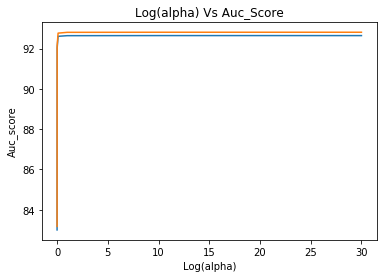

In [0]:

plt.plot(c,cv_scr)
plt.plot(c,train_scr)
plt.title("Log(alpha) Vs Auc_Score")
plt.xlabel("Log(alpha)")
plt.ylabel("Auc_score")
plt.show()


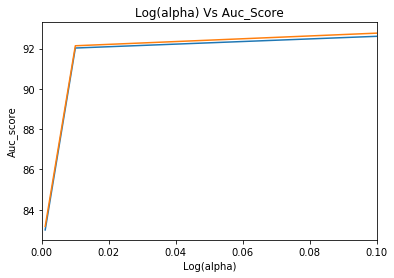

In [0]:

plt.plot(c,cv_scr)
plt.plot(c,train_scr)
plt.xlim([0,0.1])
plt.title("Log(alpha) Vs Auc_Score")
plt.xlabel("Log(alpha)")
plt.ylabel("Auc_score")
plt.show()


1. Unlike any other previous models, AVG_W2V based LR model is giving **very stable performance for wide range of C value.**
2. We are getting highest AUC_SCORE for C=20.
3. Also note that, this model is performing well on large C value unlike any other model so far 

In [0]:


from sklearn.linear_model import LogisticRegression
lr_model=LogisticRegression(C=20,penalty='l1')
lr_model.fit(avg_w2v_train_df,final['Score'][:60000])

"""Training Data"""
pred_prob_train=lr_model.predict_proba(avg_w2v_train_df)
pred_train=lr_model.predict(avg_w2v_train_df)



In [0]:


"""Test Data"""
pred_prob_test=lr_model.predict_proba(avg_w2v_test_df)
pred_test=lr_model.predict(avg_w2v_test_df)


No handles with labels found to put in legend.


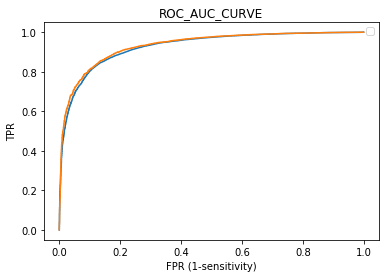

In [0]:

fpr1,tpr1,thr1=roc_curve(final['Score'][:60000],pred_prob_train[:,1])
fpr2,tpr2,thr2=roc_curve(final['Score'][60000:80000],pred_prob_test[:,1])
plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.title("ROC_AUC_CURVE")
plt.xlabel("FPR (1-sensitivity)")
plt.ylabel("TPR")
plt.legend()

plt.show()

In [0]:

roc_auc_score(final['Score'][:60000],pred_prob_train[:,1])


0.9279495661138436

In [0]:

roc_auc_score(final['Score'][60000:80000],pred_prob_test[:,1])


0.9333783319677789

1. This mode is showing somewhat different behaviour.
2. AVG_W2V based LR model is seeming to be **highly stable over wide range of C value**.
3. Looking at train & CV data AUC_SCORE...model looks very much **stable & reliable**.
4. In fact, as expected, model is giving better AUC_SCORE for train data than CV data...and beyond that it is **doing so well on test data** as well.
5. **AUC_SCORE on test data is higher than train & CV data** which is highly desirable, unlike in previous cases of BOW & TFIDF

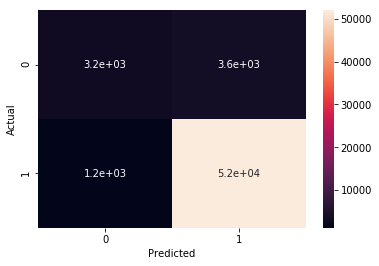

In [0]:

from sklearn.metrics import confusion_matrix

cmat_train = confusion_matrix(final['Score'][:60000],pred_train)

sns.heatmap(cmat_train,annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()




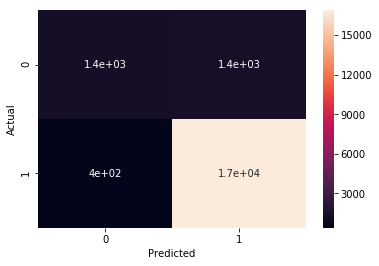

In [0]:



cmat_test = confusion_matrix(final['Score'][60000:80000],pred_test)

sns.heatmap(cmat_test,annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()



1. On train data, model is somewhat performing poor as it is wrongly predicting some positive & negative reviews.
2. On test data, model is **doing good with positive reviews** but it is still performing **poor with negative reviews.**
3. Overall, though model is giving lower AUC_SCORE with AVG_W2V than BOW & TFIDF, but it **seems to be highly generalised & reliable.**

In [0]:

from sklearn.metrics import classification_report

train_report=classification_report(final['Score'][:60000],pred_train)
print(train_report)


              precision    recall  f1-score   support

           0       0.73      0.47      0.57      6853
           1       0.93      0.98      0.96     53147

    accuracy                           0.92     60000
   macro avg       0.83      0.73      0.76     60000
weighted avg       0.91      0.92      0.91     60000



In [0]:


test_report=classification_report(final['Score'][60000:80000],pred_test)
print(test_report)

              precision    recall  f1-score   support

           0       0.77      0.50      0.61      2742
           1       0.92      0.98      0.95     17258

    accuracy                           0.91     20000
   macro avg       0.85      0.74      0.78     20000
weighted avg       0.90      0.91      0.90     20000



### [5.4.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [0]:

# Please write all the code with proper documentation

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score,roc_curve
c=[0.001, 0.01, 0.1, 1, 10, 20,30]

train_scr=[]
cv_scr=[]
for val in tqdm(c):
  
  lr_model=LogisticRegression(C=val,penalty='l2')
  auc_score=cross_validate(lr_model,avg_w2v_train_df,final['Score'][:60000],scoring='roc_auc',cv=5,return_train_score=True) # maybe here we have to pass sparse matrix...rather than bow_train_df->final_counts(sp_mat)
  train_scr.append(auc_score['train_score'].mean()*100)
  cv_scr.append(auc_score['test_score'].mean()*100)
  print("roc_auc score for c=%s is :- %s " %(val,auc_score['test_score'].mean()))



 14%|█▍        | 1/7 [00:03<00:19,  3.22s/it]

roc_auc score for c=0.001 is :- 0.9135669686228353 


 29%|██▊       | 2/7 [00:08<00:19,  3.95s/it]

roc_auc score for c=0.01 is :- 0.9246815377285442 


 43%|████▎     | 3/7 [00:15<00:19,  4.80s/it]

roc_auc score for c=0.1 is :- 0.9262489349050773 


 57%|█████▋    | 4/7 [00:23<00:17,  5.70s/it]

roc_auc score for c=1 is :- 0.9264311799687619 


 71%|███████▏  | 5/7 [00:32<00:13,  6.62s/it]

roc_auc score for c=10 is :- 0.9264438296084208 


 86%|████████▌ | 6/7 [00:40<00:07,  7.26s/it]

roc_auc score for c=20 is :- 0.9264446253403849 


100%|██████████| 7/7 [00:49<00:00,  7.66s/it]

roc_auc score for c=30 is :- 0.9264436509553982 


1. With L2 regularization also, AVG_W2V based LR model is performing very much similar to that of L1 regularized AVG_W2V LR model
2. Unlike in previous cases of BOW & TFIDF, AVG_W2V is **not showing any change in model performance with L1 & L2 regularization**.
3. Again , model is giving highest **AUC SCORE of 0.926444 with C=20**


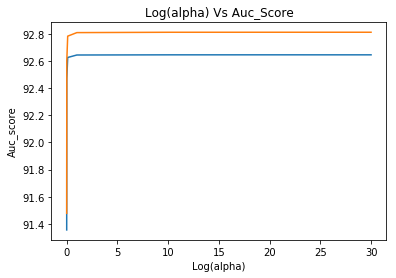

In [0]:

plt.plot(c,cv_scr)
plt.plot(c,train_scr)
plt.title("Log(alpha) Vs Auc_Score")
plt.xlabel("Log(alpha)")
plt.ylabel("Auc_score")
plt.show()



We can easily notice that...model is being very much stable for wide range of C value.

In [0]:

from sklearn.linear_model import LogisticRegression
lr_model=LogisticRegression(C=20,penalty='l2')
lr_model.fit(avg_w2v_train_df,final['Score'][:60000])

"""Training Data"""
pred_prob_train=lr_model.predict_proba(avg_w2v_train_df)
pred_train=lr_model.predict(avg_w2v_train_df)



In [0]:


"""Test Data"""
pred_prob_test=lr_model.predict_proba(avg_w2v_test_df)
pred_test=lr_model.predict(avg_w2v_test_df)



No handles with labels found to put in legend.


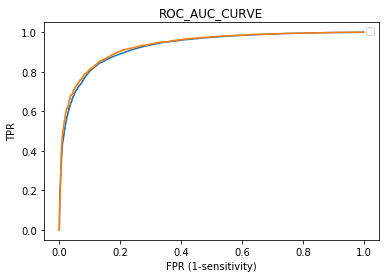

In [0]:

fpr1,tpr1,thr1=roc_curve(final['Score'][:60000],pred_prob_train[:,1])
fpr2,tpr2,thr2=roc_curve(final['Score'][60000:80000],pred_prob_test[:,1])
plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.title("ROC_AUC_CURVE")
plt.xlabel("FPR (1-sensitivity)")
plt.ylabel("TPR")
plt.legend()

plt.show()


In [0]:

roc_auc_score(final['Score'][:60000],pred_prob_train[:,1])



0.9279583081696069

In [0]:

roc_auc_score(final['Score'][60000:80000],pred_prob_test[:,1])



0.9333947515878427

1. Similar to previous model with L1 regularization, this model is also **performing very well on test data.**
2. It is giving higher AUC_SCORE on test data than train data.
3. Therefore , it can be said that , model is **highly generalised and reliable.**

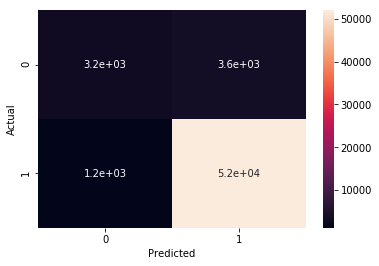

In [0]:

from sklearn.metrics import confusion_matrix

cmat_train = confusion_matrix(final['Score'][:60000],pred_train)

sns.heatmap(cmat_train,annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()



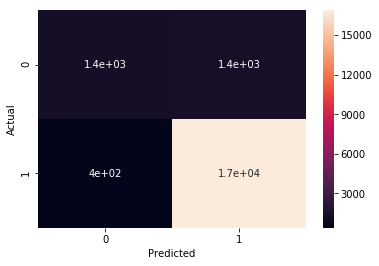

In [0]:


cmat_test = confusion_matrix(final['Score'][60000:80000],pred_test)

sns.heatmap(cmat_test,annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()




1. Looking at above confusion matrix , we can easily notice that, model is almost exactly performing same as that of previous model with L1 regularisation.
2. Somewhat performing poor on negative reviews than positive reviews.
2. It shows that, There is **no any significant effect of of L1 over L2 regularization or vice versa with AVG_W2V vectorized data.**

In [0]:

from sklearn.metrics import classification_report

train_report=classification_report(final['Score'][:60000],pred_train)
print(train_report)


              precision    recall  f1-score   support

           0       0.73      0.47      0.57      6853
           1       0.94      0.98      0.96     53147

    accuracy                           0.92     60000
   macro avg       0.83      0.73      0.76     60000
weighted avg       0.91      0.92      0.91     60000



In [0]:

test_report=classification_report(final['Score'][60000:80000],pred_test)
print(test_report)

              precision    recall  f1-score   support

           0       0.77      0.50      0.61      2742
           1       0.92      0.98      0.95     17258

    accuracy                           0.91     20000
   macro avg       0.85      0.74      0.78     20000
weighted avg       0.90      0.91      0.90     20000



Looking at overall performance , model is doing well.

## [5.5] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.5.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:



# Please write all the code with proper documentation

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score,roc_curve
c=[0.001, 0.01, 0.1, 1, 10, 20,30]

train_scr=[]
cv_scr=[]
for val in tqdm(c):
  
  lr_model=LogisticRegression(C=val,penalty='l1')
  auc_score=cross_validate(lr_model,tfidf_train_df,final['Score'][:60000],scoring='roc_auc',cv=5,return_train_score=True) # maybe here we have to pass sparse matrix...rather than bow_train_df->final_counts(sp_mat)
  train_scr.append(auc_score['train_score'].mean()*100)
  cv_scr.append(auc_score['test_score'].mean()*100)
  print("roc_auc score for c=%s is :- %s " %(val,auc_score['test_score'].mean()))




 14%|█▍        | 1/7 [00:02<00:15,  2.53s/it]

roc_auc score for c=0.001 is :- 0.8124867869018418 



 29%|██▊       | 2/7 [00:19<00:33,  6.78s/it]

roc_auc score for c=0.01 is :- 0.8938823002972953 



 43%|████▎     | 3/7 [00:31<00:33,  8.41s/it]

roc_auc score for c=0.1 is :- 0.9009872009987216 



 57%|█████▋    | 4/7 [01:52<01:30, 30.20s/it]

roc_auc score for c=1 is :- 0.9013678142418279 



 71%|███████▏  | 5/7 [03:15<01:31, 45.97s/it]

roc_auc score for c=10 is :- 0.9013706177597938 



 86%|████████▌ | 6/7 [04:35<00:56, 56.32s/it]

roc_auc score for c=20 is :- 0.9013653989500254 



100%|██████████| 7/7 [06:04<00:00, 66.14s/it]


roc_auc score for c=30 is :- 0.9013648910067144 


1. Like BOW & TFIDF but unlike AVG_W2V based LR model, TFIDF_W2V model is **showing variations in model performance with C value**. While after a certain value of C , performance is almost constant.
2. Model is giving highest AUC_SCORE of **0.901370 with C=10**
3. **Though model is showing stable performance** over wide range of C, **AUC_SCORE is quite lower than all other previous models.**

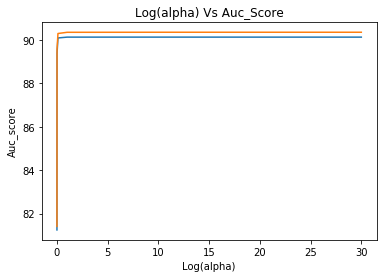

In [0]:

plt.plot(c,cv_scr)
plt.plot(c,train_scr)
plt.title("Log(alpha) Vs Auc_Score")
plt.xlabel("Log(alpha)")
plt.ylabel("Auc_score")
plt.show()




It seems that, model is performing **amost similar on train and CV data**. It is **expected that model will perform better on test data than train data**, like in previous case of AVG_W2V.

In [0]:

from sklearn.linear_model import LogisticRegression
lr_model=LogisticRegression(C=10,penalty='l1')
lr_model.fit(tfidf_train_df,final['Score'][:60000])

"""Training Data"""
pred_prob_train=lr_model.predict_proba(tfidf_train_df)
pred_train=lr_model.predict(tfidf_train_df)



In [0]:

"""Test Data"""
pred_prob_test=lr_model.predict_proba(tfidf_test_df)
pred_test=lr_model.predict(tfidf_test_df)



No handles with labels found to put in legend.


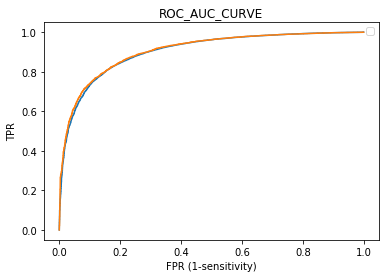

In [0]:


fpr1,tpr1,thr1=roc_curve(final['Score'][:60000],pred_prob_train[:,1])
fpr2,tpr2,thr2=roc_curve(final['Score'][60000:80000],pred_prob_test[:,1])
plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.title("ROC_AUC_CURVE")
plt.xlabel("FPR (1-sensitivity)")
plt.ylabel("TPR")
plt.legend()

plt.show()


Visually also, we can easily notice that...model is performing almost exactly same on train and test data.

In [0]:

roc_auc_score(final['Score'][:60000],pred_prob_train[:,1])



0.9034032422225611

In [0]:

roc_auc_score(final['Score'][60000:80000],pred_prob_test[:,1])



0.9070051678059812

As expected , model is giving slightly **better AUC_SCORE on test dataset than train datas**et.

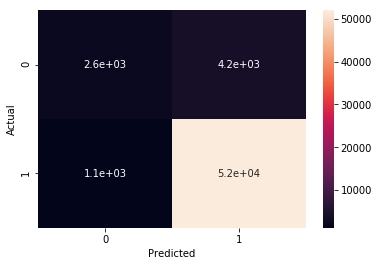

In [0]:

from sklearn.metrics import confusion_matrix

cmat_train = confusion_matrix(final['Score'][:60000],pred_train)

sns.heatmap(cmat_train,annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


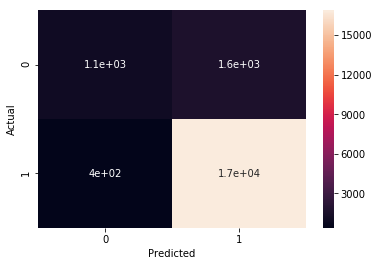

In [0]:


cmat_test = confusion_matrix(final['Score'][60000:80000],pred_test)

sns.heatmap(cmat_test,annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()










1. Model is again disappointing by not performing well on negative reviews. While it showing improvement with positive reviews.


In [0]:


from sklearn.metrics import classification_report

train_report=classification_report(final['Score'][:60000],pred_train)
print(train_report)


              precision    recall  f1-score   support

           0       0.69      0.38      0.49      6853
           1       0.92      0.98      0.95     53147

    accuracy                           0.91     60000
   macro avg       0.81      0.68      0.72     60000
weighted avg       0.90      0.91      0.90     60000



In [0]:

test_report=classification_report(final['Score'][60000:80000],pred_test)
print(test_report)

              precision    recall  f1-score   support

           0       0.73      0.40      0.52      2742
           1       0.91      0.98      0.94     17258

    accuracy                           0.90     20000
   macro avg       0.82      0.69      0.73     20000
weighted avg       0.89      0.90      0.88     20000



Notice the performance metrics in classification report for negative reviews, though it is showing poor performance with negative reviews on test data, it can be seen through the **classification report** that, as **compared to previous models**, performance metrics(**f1-score, recall,precision**) is **showing improvement on negative reviews** from train data to test data.

### [5.5.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score,roc_curve
c=[0.001, 0.01, 0.1, 1, 10, 20,30]

train_scr=[]
cv_scr=[]
for val in tqdm(c):
  
  lr_model=LogisticRegression(C=val,penalty='l2')
  auc_score=cross_validate(lr_model,tfidf_train_df,final['Score'][:60000],scoring='roc_auc',cv=5,return_train_score=True) # maybe here we have to pass sparse matrix...rather than bow_train_df->final_counts(sp_mat)
  train_scr.append(auc_score['train_score'].mean()*100)
  cv_scr.append(auc_score['test_score'].mean()*100)
  print("roc_auc score for c=%s is :- %s " %(val,auc_score['test_score'].mean()))




 14%|█▍        | 1/7 [00:04<00:24,  4.07s/it]

roc_auc score for c=0.001 is :- 0.885071759475542 



 29%|██▊       | 2/7 [00:10<00:23,  4.67s/it]

roc_auc score for c=0.01 is :- 0.8988369095011247 



 43%|████▎     | 3/7 [00:19<00:23,  5.93s/it]

roc_auc score for c=0.1 is :- 0.9011316082693461 



 57%|█████▋    | 4/7 [00:28<00:21,  7.10s/it]

roc_auc score for c=1 is :- 0.9013658329827227 



 71%|███████▏  | 5/7 [00:38<00:15,  7.99s/it]

roc_auc score for c=10 is :- 0.9013638062093197 



 86%|████████▌ | 6/7 [00:49<00:08,  8.67s/it]

roc_auc score for c=20 is :- 0.9013614991572517 



100%|██████████| 7/7 [00:59<00:00,  9.10s/it]


roc_auc score for c=30 is :- 0.9013611002002065 


1. Model is very much steady over wide range of C value.
2. We are getting Higher AUC_SCORE of 0.901365 with C=1
3. Notice that for TFIDF_W2V L2 regularized LR model , Best value for hyperparameter has reduced to 1 from 10/20 being for AVG_W2V  LR model.

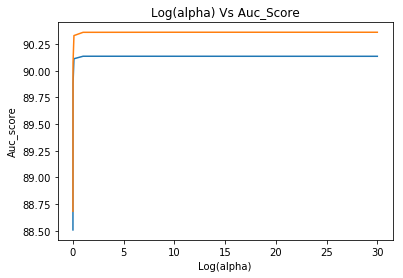

In [0]:

plt.plot(c,cv_scr)
plt.plot(c,train_scr)
plt.title("Log(alpha) Vs Auc_Score")
plt.xlabel("Log(alpha)")
plt.ylabel("Auc_score")
plt.show()





Unlike with AVG_W2V model (both L1 & L2 regularized), in TFIDF_W2V there is a slight difference in AUC SCORE between train and CV data.




In [0]:
from sklearn.linear_model import LogisticRegression
lr_model=LogisticRegression(C=10,penalty='l2')
lr_model.fit(tfidf_train_df,final['Score'][:60000])

"""Training Data"""
pred_prob_train=lr_model.predict_proba(tfidf_train_df)
pred_train=lr_model.predict(tfidf_train_df)




In [0]:
"""Test Data"""
pred_prob_test=lr_model.predict_proba(tfidf_test_df)
pred_test=lr_model.predict(tfidf_test_df)




No handles with labels found to put in legend.


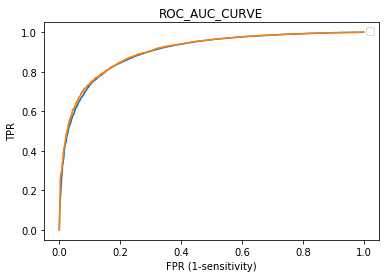

In [0]:
fpr1,tpr1,thr1=roc_curve(final['Score'][:60000],pred_prob_train[:,1])
fpr2,tpr2,thr2=roc_curve(final['Score'][60000:80000],pred_prob_test[:,1])
plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.title("ROC_AUC_CURVE")
plt.xlabel("FPR (1-sensitivity)")
plt.ylabel("TPR")
plt.legend()

plt.show()


In [0]:

roc_auc_score(final['Score'][:60000],pred_prob_train[:,1])



0.9033984566059796

In [0]:

roc_auc_score(final['Score'][60000:80000],pred_prob_test[:,1])



0.907017868181346

1. Though there was a slight difference in AUC_SCORE between train and CV data , model is performing well on test data, in fact giving slightly better AUC_SCORE on test data than train data.
2. It is behaving same for L1 & L2 regularization, like in previous case of AVG_W2V.


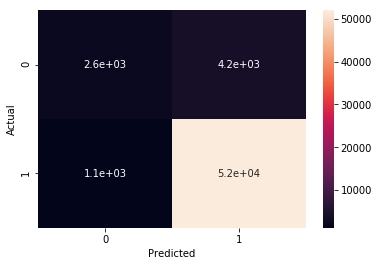

In [0]:

from sklearn.metrics import confusion_matrix

cmat_train = confusion_matrix(final['Score'][:60000],pred_train)

sns.heatmap(cmat_train,annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


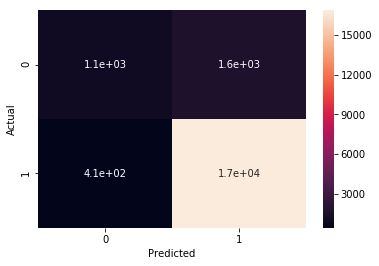

In [0]:


cmat_test = confusion_matrix(final['Score'][60000:80000],pred_test)

sns.heatmap(cmat_test,annot=True)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()







1. Again, this model is also performing bit poor on negative reviews , though there is a better performance with positive reviews on test data.
2. Notice that, though model is behaving somewhat different from one another, but all 4 models (AVG_W2V & TFIDF_W2V with L1 & L2 regularization) are performing almost same on positive and negative revies , though AUC_SCORE between them differs somewhat.

In [0]:





from sklearn.metrics import classification_report

train_report=classification_report(final['Score'][:60000],pred_train)
print(train_report)


              precision    recall  f1-score   support

           0       0.69      0.38      0.49      6853
           1       0.92      0.98      0.95     53147

    accuracy                           0.91     60000
   macro avg       0.81      0.68      0.72     60000
weighted avg       0.90      0.91      0.90     60000



In [0]:

test_report=classification_report(final['Score'][60000:80000],pred_test)
print(test_report)

              precision    recall  f1-score   support

           0       0.73      0.40      0.52      2742
           1       0.91      0.98      0.94     17258

    accuracy                           0.90     20000
   macro avg       0.82      0.69      0.73     20000
weighted avg       0.89      0.90      0.88     20000



It seems that, this model is performing quite poor than previously 3 models (AVG_W2V with L1 & L2 and TFIDF_W2V with L1)

# [6] Conclusions

1. There was almost same behaviour of BOW and Bigrajm-BOW on train and test data. Though Bigram-BOW is comparatively well generalised than Unigram-BOW

2. TFIDF is found to be performing slightly better than BOW (unigram). Also somewhat better than Bigram-BOW also

3. In BOW (unigram) and TFIDF ... top 10 positive features are almost same except the only feature.

4. While Bigram-BOW is giving slightly diffrent features as top positive features but maximum are similar to that of BOW & TFIDF.

5. And Top Negative features are same for BOW (unigram) and TFIDF, except the only one. While again its slightly different for Bigram-BOW

## Important Features

In [0]:
from prettytable import PrettyTable
table_pos=PrettyTable()
table_neg=PrettyTable()


In [0]:
index=["tokenization",1,2,3,4,5,6,7,8,9]

bow=['BOW','delicious',
 'excellent',
 'perfect',
 'yummy',
 'loves',
 'best',
 'wonderful',
 'yum',
 'great']  

bigram_bow=['Bigram-BOW',
 'excellent',
 'not disappointed',
 'perfect',
 'yummy',
 'loves',  
 'best',
 'wonderful',
 'great',
 'not bad']

tfidf=['TFIDF','great',
 'best',
 'delicious',
 'excellent',  
 'good',
 'perfect',
 'love',
 'wonderful',
 'loves']

table_pos.add_column("class label",index)
table_pos.add_column("-",bow)
table_pos.add_column("Positive",bigram_bow)
table_pos.add_column("--",tfidf)

In [0]:
print(table_pos)

+--------------+-----------+------------------+-----------+
| class label  |     -     |     Positive     |     --    |
+--------------+-----------+------------------+-----------+
| tokenization |    BOW    |    Bigram-BOW    |   TFIDF   |
|      1       | delicious |    excellent     |   great   |
|      2       | excellent | not disappointed |    best   |
|      3       |  perfect  |     perfect      | delicious |
|      4       |   yummy   |      yummy       | excellent |
|      5       |   loves   |      loves       |    good   |
|      6       |    best   |       best       |  perfect  |
|      7       | wonderful |    wonderful     |    love   |
|      8       |    yum    |      great       | wonderful |
|      9       |   great   |     not bad      |   loves   |
+--------------+-----------+------------------+-----------+


* Notice that, I have printed only top 9 positive features due to some silly mistakes.
Kindly accept it.

In [0]:
index=["Tokenization",1,2,3,4,5,6,7,8,9,10]

bow=['BOW','worst',
 'disappointing',
 'terrible',
 'awful',
 'bland',
 'yuck',
 'horrible',
 'disappointed',
 'disappointment',
 'threw']

bigram_bow=['Bigram-BOW','worst',
 'not worth',
 'disappointing',
 'not great',
 'terrible',
 'disappointed',
 'not good',
 'awful',
 'horrible',
 'bland']   

tfidf=['TFIDF','not',
 'worst',
 'disappointed',
 'disappointing',
 'terrible',
 'awful',
 'horrible',
 'bland',
 'yuck',
 'disappointment']

table_neg.add_column("class label",index)
table_neg.add_column("-",bow)
table_neg.add_column("Negative",bigram_bow)
table_neg.add_column("--",tfidf)

In [0]:
print(table_neg)

+--------------+----------------+---------------+----------------+
| class label  |       -        |    Negative   |       --       |
+--------------+----------------+---------------+----------------+
| Tokenization |      BOW       |   Bigram-BOW  |     TFIDF      |
|      1       |     worst      |     worst     |      not       |
|      2       | disappointing  |   not worth   |     worst      |
|      3       |    terrible    | disappointing |  disappointed  |
|      4       |     awful      |   not great   | disappointing  |
|      5       |     bland      |    terrible   |    terrible    |
|      6       |      yuck      |  disappointed |     awful      |
|      7       |    horrible    |    not good   |    horrible    |
|      8       |  disappointed  |     awful     |     bland      |
|      9       | disappointment |    horrible   |      yuck      |
|      10      |     threw      |     bland     | disappointment |
+--------------+----------------+---------------+-------------

# Score Evaluation

In [0]:
from prettytable import PrettyTable

table=PrettyTable()
table.field_names=["Vectorization","--","MultinomialNB ( L1 Reg )","- "]
#print(table)
table.add_row(["---","Train","CV","Test"])
#print(table)

In [0]:


bow=["BOW",0.9881,0.9482,0.9575]
bow_bigram=["Bi-gram BOW",0.9928,0.9557,0.960 ]
tfidf=["TFIDF",0.9718,0.9593,0.9637]
avgw2v=['AVG_W2V',0.9279,0.9264,0.9333]
tfidfw2v=['TFIDF_W2V',0.9034,0.9013,0.9070]

table.add_row(bow)
table.add_row(bow_bigram)
table.add_row(tfidf)
table.add_row(avgw2v)
table.add_row(tfidfw2v)

print(table)

+---------------+--------+--------------------------+--------+
| Vectorization |   --   | MultinomialNB ( L1 Reg ) |   -    |
+---------------+--------+--------------------------+--------+
|      ---      | Train  |            CV            |  Test  |
|      BOW      | 0.9881 |          0.9482          | 0.9575 |
|  Bi-gram BOW  | 0.9928 |          0.9557          |  0.96  |
|     TFIDF     | 0.9718 |          0.9593          | 0.9637 |
|    AVG_W2V    | 0.9279 |          0.9264          | 0.9333 |
|   TFIDF_W2V   | 0.9034 |          0.9013          | 0.907  |
+---------------+--------+--------------------------+--------+


In [0]:
from prettytable import PrettyTable

table=PrettyTable()
table.field_names=["Vectorization","--","MultinomialNB ( L2 Reg )","- "]
#print(table)
table.add_row(["---","Train","CV","Test"])
#print(table)

bow=["BOW",0.9799,0.9539,0.9579]
bow_bigram=["Bi-gram BOW",0.9855,0.9608,0.9658 ]
tfidf=["TFIDF",0.9774,0.9621,0.9669]
avgw2v=['AVG_W2V',0.9279,0.9264,0.9333]
tfidfw2v=['TFIDF_W2V',0.9033,0.9013,0.9070]

table.add_row(bow)
table.add_row(bow_bigram)
table.add_row(tfidf)
table.add_row(avgw2v)
table.add_row(tfidfw2v)

print(table)

+---------------+--------+--------------------------+--------+
| Vectorization |   --   | MultinomialNB ( L2 Reg ) |   -    |
+---------------+--------+--------------------------+--------+
|      ---      | Train  |            CV            |  Test  |
|      BOW      | 0.9799 |          0.9539          | 0.9579 |
|  Bi-gram BOW  | 0.9855 |          0.9608          | 0.9658 |
|     TFIDF     | 0.9774 |          0.9621          | 0.9669 |
|    AVG_W2V    | 0.9279 |          0.9264          | 0.9333 |
|   TFIDF_W2V   | 0.9033 |          0.9013          | 0.907  |
+---------------+--------+--------------------------+--------+


##Final Thoughts:-

**1. Bow:-**
* BOW with 1-gram is performing very well on train and test data with higher AUC_SCORE

**2. BOW-Bigram:-**
* Bigram-BOW is perfroming **exceptionally well** on train and test data. 
* Quite better than unigram BOW as it is giving well generalised model.

**3. TFIDF:-**
* TFIDF is also performing almost similar to BOW (Bigram) as it is capable of building highly generalised model.
* In fact it seems to be slightly better than Bigram-BOW model.

**4. AVG_W2V:-**
* Though this model is stable over wide range of C value and has less difference between CV and Test data AUC_SCORE, it is giving quite lower AUC_SCORE than other three ( bow (unigram & bigram) & tfidf ) models.

**5. TFIDF_W2V:-**
* It is performing almost similar to that of AVG_W2V model and lagging behind when it comes to higher AUC_SCORE.

**4**.When it comes to **final decision**, in our case we would surely proceed with ***TFIDF LR model*** as it is capable of building **highly generalised model**.
